# Import Required Libraries

In [1]:
WANDB = True
EXP_NAME = "val11-a1_effnetb0_balanced_mixup"
# EXP_NAME = "try"

if WANDB:
    # !pip install wandb
    import wandb
    import os
    from dotenv import load_dotenv
    load_dotenv()
    wandb.login(key=os.environ.get("WANDB_API_KEY"))

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: trira7503. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [2]:
import os
import gc
import cv2
import math
import copy
import time
import random
import glob
from matplotlib import pyplot as plt
import seaborn as sns
from PIL import Image

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.cuda import amp
import torchvision
from torch.distributions.beta import Beta
# from torcheval.metrics.functional import binary_auroc

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold 
from sklearn.metrics import roc_auc_score

# For Image Models
import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Training Configuration

In [3]:
CONFIG = {
    "seed": 42,
    "epochs": 90,
    # "epochs": 3, #######　後でなおすこと
    "img_size": 224,
    "model_name": "tf_efficientnet_b0_ns",
    "checkpoint_path" : "/kaggle/input/tf-efficientnet/pytorch/tf-efficientnet-b0/1/tf_efficientnet_b0_aa-827b6e33.pth",
    "train_batch_size": 64,
    "valid_batch_size": 128,
    "learning_rate": 1e-3,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 5e-8,
#     "T_max": 10316,
    "weight_decay": 1e-5,
    "fold" : 0,
    "n_fold": 5,
    "n_accumulate": 1,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    "save_dir": "../proc/val3",
    "use_tta": False,
    "mixup_alpha": 0.2,  # 既存のMixupのパラメータ
    "mixup_epochs": 60,  # Mixupを適用するエポック数を追加
    "focal_alpha": 0.7,
    "focal_gamma": 3,
}

# Set Seed for Reproducibility

In [4]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [5]:
ROOT_DIR = "../raw"
TRAIN_DIR = f'{ROOT_DIR}/train-image/image'

In [6]:
def get_train_file_path(image_id):
    return f"{TRAIN_DIR}/{image_id}.jpg"

# Read the Data

In [7]:
train_images = sorted(glob.glob(f"{TRAIN_DIR}/*.jpg"))

In [8]:
df = pd.read_csv(f"{ROOT_DIR}/train-metadata.csv")
print(df.shape)
df['file_path'] = df['isic_id'].apply(get_train_file_path)
df = df[ df["file_path"].isin(train_images) ].reset_index(drop=True)
df

(401059, 55)


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,file_path
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282,../raw/train-image/image/ISIC_0015670.jpg
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455,../raw/train-image/image/ISIC_0015845.jpg
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040,../raw/train-image/image/ISIC_0015864.jpg
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998,../raw/train-image/image/ISIC_0015902.jpg
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510,../raw/train-image/image/ISIC_0024200.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,ISIC_9999937,0,IP_1140263,70.0,male,anterior torso,6.80,TBP tile: close-up,3D: XP,22.574335,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999988,../raw/train-image/image/ISIC_9999937.jpg
401055,ISIC_9999951,0,IP_5678181,60.0,male,posterior torso,3.11,TBP tile: close-up,3D: white,19.977640,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999820,../raw/train-image/image/ISIC_9999951.jpg
401056,ISIC_9999960,0,IP_0076153,65.0,female,anterior torso,2.05,TBP tile: close-up,3D: XP,17.332567,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999416,../raw/train-image/image/ISIC_9999960.jpg
401057,ISIC_9999964,0,IP_5231513,30.0,female,anterior torso,2.80,TBP tile: close-up,3D: XP,22.288570,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,../raw/train-image/image/ISIC_9999964.jpg


In [9]:
df_patient = df.groupby("patient_id")[["isic_id"]].agg(
    count_per_patient=("isic_id", "count"), 
).sort_values(by="count_per_patient").reset_index()
df_patient.head(2)

,patient_id,count_per_patient
0,IP_5792391,1
1,IP_1487179,1


In [10]:
df = df.merge(df_patient, on="patient_id", how="left")
df.shape[0], df.target.sum()

(401059, 393)

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Create Folds</h1></span>

In [11]:
sgkf = StratifiedGroupKFold(n_splits=CONFIG['n_fold'], shuffle=True, random_state=0)

for fold, ( _, val_) in enumerate(sgkf.split(df, df.target, df.patient_id)):
      df.loc[val_ , "kfold"] = int(fold)
        
# df[["isic_id", "kfold"]].to_csv("df_fold.csv", index=False)
df[["isic_id", "kfold"]]

,isic_id,kfold
0,ISIC_0015670,4.0
1,ISIC_0015845,2.0
2,ISIC_0015864,1.0
3,ISIC_0015902,2.0
4,ISIC_0024200,1.0
...,...,...
401054,ISIC_9999937,1.0
401055,ISIC_9999951,3.0
401056,ISIC_9999960,0.0
401057,ISIC_9999964,2.0


In [12]:
list_remove = [
    "ISIC_0573025",
    "ISIC_1443812",
    "ISIC_5374420",
    "ISIC_2611119",
    "ISIC_2691718",
    "ISIC_9689783",
    "ISIC_9520696",
    "ISIC_8651165",
    "ISIC_9385142",
    "ISIC_9680590"
]
print(df.shape[0], df.target.sum())
df = df[~df["isic_id"].isin(list_remove)].reset_index(drop=True)
print(df.shape[0], df.target.sum())

401059 393
401049 393


In [13]:
df["target_original"] = df["target"]
df.loc[(df["iddx_full"]!="Benign")&(df["target"]!=1), "target"] = 1
print(df.shape[0], df.target.sum())

401049 1065


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Dataset Class</h1></span>

In [14]:
class ISICDataset_for_Train(Dataset):
    def __init__(self, df, transforms=None):
        self.df_positive = df[df["target"] == 1].reset_index()
        self.df_negative = df[df["target"] == 0].reset_index()
        self.file_names_positive = self.df_positive['file_path'].values
        self.file_names_negative = self.df_negative['file_path'].values
        self.targets_positive = self.df_positive['target'].values
        self.targets_negative = self.df_negative['target'].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df_positive) * 2
    
    def __getitem__(self, index):
        if random.random() >= 0.9:
            df = self.df_positive
            file_names = self.file_names_positive
            targets = self.targets_positive
        else:
            df = self.df_negative
            file_names = self.file_names_negative
            targets = self.targets_negative
        index = index % df.shape[0]
        
        img_path = file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        target = targets[index]
        
        if self.transforms:
            img = self.transforms(image=img)["image"]
            
        return {
            'image': img,
            'target': target
        }

class ISICDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.targets = df['target'].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = self.file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        target = self.targets[index]
        
        if self.transforms:
            img = self.transforms(image=img)["image"]
            
        return {
            'image': img,
            'target': target
        }
    
class ISICDataset_mixup(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.targets = df['target'].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = self.file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        target = self.targets[index]
        
        if self.transforms:
            img = self.transforms(image=img)["image"]
            
        return img, target

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Augmentations</h1></span>

In [15]:
# # Mixupを行う関数を追加
# def mixup(x: torch.Tensor, y: torch.Tensor, alpha: float = 0.4):
#     assert alpha > 0, "alpha should be larger than 0"
#     assert x.size(0) > 1, "Batch size should be larger than 1"

#     lam = np.random.beta(alpha, alpha)
#     rand_index = torch.randperm(x.size()[0])
#     mixed_x = lam * x + (1 - lam) * x[rand_index, :]
#     target_a, target_b = y, y[rand_index]
#     return mixed_x, target_a, target_b, lam

# Balanced Mixupを行う関数を追加
# def balanced_mixup(x, y, alpha=0.2):
#     """
#     Balanced MixUp の実装

#     Args:
#         x (torch.Tensor): 入力データ (バッチサイズ, チャネル数, 高さ, 幅)
#         y (torch.Tensor): ラベル (バッチサイズ)
#         alpha (float): MixUp の強度を制御するハイパーパラメータ

#     Returns:
#         mixed_x (torch.Tensor): MixUp 後の入力データ
#         mixed_y (torch.Tensor): MixUp 後のラベル
#     """

#     batch_size = x.size(0)

#     # インスタンスベースのサンプリング
#     index_instance = torch.randperm(batch_size)

#     # クラスベースのサンプリング
#     # y が0と1のバイナリラベルを持つと仮定
#     class0_indices = torch.where(y == 0)[0]
#     class1_indices = torch.where(y == 1)[0]

#     # 各クラスから同じ数をサンプリング
#     sampled_class0_indices = class0_indices[torch.randint(0, len(class0_indices), (batch_size // 2,), device=x.device)]
#     sampled_class1_indices = class1_indices[torch.randint(0, len(class1_indices), (batch_size // 2,), device=x.device)]

#     # サンプリングしたインデックスを結合
#     sampled_indices = torch.cat([sampled_class0_indices, sampled_class1_indices])

#     # インデックスをシャッフル
#     index_class = sampled_indices[torch.randperm(len(sampled_indices), device=x.device)]

#     # λ（ラムダ）を Beta(α, 1) からサンプリング
#     lam = Beta(torch.tensor([alpha], device=x.device), torch.tensor([1.0], device=x.device)).sample([batch_size])
#     lam = torch.max(lam, 1 - lam)  # λ >= 0.5 を保証

#     # MixUp
#     mixed_x = lam.view(-1, 1, 1, 1) * x + (1 - lam).view(-1, 1, 1, 1) * x[index_class]
#     mixed_y = lam.view(-1, 1) * F.one_hot(y.long(), num_classes=2) + (1 - lam).view(-1, 1) * F.one_hot(y[index_class].long(), num_classes=2)

#     return mixed_x, mixed_y

In [16]:
class BalancedMixUp:
    def __init__(self, alpha=0.2):
        self.alpha = alpha

    def __call__(self, x_instance, y_instance, x_class, y_class):
        # ベータ分布からλをサンプリング
        lam = torch.distributions.beta.Beta(self.alpha, 1).sample()
        lam = lam.to(x_instance.device)

        # 新しい合成サンプルを生成
        x_mixed = lam * x_instance + (1 - lam) * x_class
        y_mixed = lam * y_instance + (1 - lam) * y_class
        # x_mixed = lam * x_class + (1 - lam) * x_instance
        # y_mixed = lam * y_class + (1 - lam) * y_instance

        return x_mixed, y_mixed, lam

def get_class_based_sampler(dataset, labels):
    # 各クラスの頻度を計算
    class_counts = torch.bincount(labels)
    num_samples = len(labels)

    # 各クラスのサンプリング確率を計算
    class_weights = 1.0 / class_counts.float()
    sample_weights = class_weights[labels]

    # サンプリング用のWeightedRandomSamplerを作成
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=num_samples, replacement=True)
    return sampler

In [17]:
data_transforms = {
    "train": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.RandomRotate90(p=0.5),
        A.Flip(p=0.5),
        A.Downscale(p=0.25),
        A.ShiftScaleRotate(shift_limit=0.1, 
                           scale_limit=0.15, 
                           rotate_limit=60, 
                           p=0.5),
        A.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
        A.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.),
    
    "valid": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.)
}

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">GeM Pooling</h1></span>

In [18]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Create Model</h1></span>

In [19]:
class ISICModel(nn.Module):
    def __init__(self, model_name, num_classes=1, pretrained=True, checkpoint_path=None):
        super(ISICModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, checkpoint_path=checkpoint_path)

        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Identity()
        self.model.global_pool = nn.Identity()
        self.pooling = GeM()
        self.dropout = nn.Dropout(p=0.2)
        self.linear = nn.Linear(in_features, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, images):
        features = self.model(images)
        pooled_features = self.pooling(features).flatten(1)
        dropped_features = self.dropout(pooled_features)
        output = self.sigmoid(self.linear(dropped_features))
        return output

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Loss Function</h1></span>

In [20]:
# class FocalLoss(nn.Module):
#     def __init__(self, alpha=0.5, gamma=2, reduction='mean'):
#         super(FocalLoss, self).__init__()
#         self.alpha = alpha
#         self.gamma = gamma
#         self.reduction = reduction

#     def forward(self, inputs, targets):
#         BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(inputs, targets)
#         pt = torch.exp(-BCE_loss)
#         F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

#         if self.reduction == 'mean':
#             return F_loss.mean()
#         elif self.reduction == 'sum':
#             return F_loss.sum()
#         else:
#             return F_loss

class FocalLoss(nn.Module):
    def __init__(self, weight=None, alpha=0.5, gamma=2, reduction="mean"):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #first compute binary cross-entropy 
        BCE = nn.CrossEntropyLoss()(inputs, targets)
        BCE_EXP = torch.exp(-BCE)
        focal_loss = self.alpha * (1-BCE_EXP)**self.gamma * BCE

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# focal_loss = FocalLoss(alpha=CONFIG["focal_alpha"], gamma=CONFIG["focal_gamma"], reduction='mean')

def criterion(outputs, targets):
    return nn.BCELoss()(outputs, targets)
    # return nn.BCEWithLogitsLoss()(outputs, targets)
    # return nn.CrossEntropyLoss()(outputs, targets) 
    # return FocalLoss(alpha=CONFIG["focal_alpha"], gamma=CONFIG["focal_gamma"])(outputs, targets)


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Training Function</h1></span>

In [21]:
def comp_score_list(solution: list, submission: list, min_tpr: float=0.80):
    v_gt = np.abs(np.array(solution)-1)
    v_pred = np.array([1.0 - x for x in submission])
    max_fpr = abs(1-min_tpr)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
    # https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    return partial_auc

In [22]:
def train_one_epoch(model, optimizer, scheduler, i_loader, c_loader, device, epoch, mixup):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    bar = tqdm(zip(i_loader, c_loader), total=len(i_loader))
    for step, (i_data, c_data) in enumerate(bar):
        # Mixupを設定されたエポック数まで適用
        if epoch <= CONFIG['mixup_epochs']:
            x_instance, y_instance = i_data
            x_class, y_class = c_data

            x_instance = x_instance.to(device, dtype=torch.float)
            y_instance = y_instance.to(device, dtype=torch.float)
            x_class = x_class.to(device, dtype=torch.float)
            y_class = y_class.to(device, dtype=torch.float)
            images, targets, lam = mixup(x_instance, y_instance, x_class, y_class)
            batch_size = images.size(0)
            outputs = model(images).squeeze()
            loss = lam * criterion(outputs, y_class) + (1 - lam) * criterion(outputs, y_instance)
        
        else:
            images, targets = c_data
            images = images.to(device, dtype=torch.float)
            targets = targets.to(device, dtype=torch.float)
            batch_size = images.size(0)
            outputs = model(images).squeeze()
            loss = criterion(outputs, targets)
            
        loss = loss / CONFIG['n_accumulate']
            
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    
    gc.collect()
    
    return epoch_loss

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Validation Function</h1></span>

In [23]:
@torch.inference_mode()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    running_auroc = 0.0
    
    # TTAのためのカウンター
    tta_counter = 0
    
    # TTAのための関数を定義
    def apply_tta(model, image):
        outputs = []
        
        # オリジナル画像
        outputs.append(model(image).squeeze())
        
        # 水平フリップ
        outputs.append(model(torch.flip(image, dims=[3])).squeeze())
        
        # 垂直フリップ
        outputs.append(model(torch.flip(image, dims=[2])).squeeze())
        
        # 90度、180度、270度回転
        for k in [1, 2, 3]:
            outputs.append(model(torch.rot90(image, k, dims=[2,3])).squeeze())
        
        return torch.stack(outputs).mean(dim=0)
    
    all_outputs = []
    all_targets = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        images = data['image'].to(device, dtype=torch.float)
        targets = data['target'].to(device, dtype=torch.float)
        
        batch_size = images.size(0)

        if CONFIG['use_tta']:
            outputs = apply_tta(model, images).squeeze()
        else:
            outputs = model(images).squeeze()
        loss = criterion(outputs, targets)
        
        all_outputs.extend(outputs.detach().cpu().numpy().flatten())  # 確率に変換して蓄積
        all_targets.extend(targets.detach().cpu().numpy().flatten())  # ラベルを蓄積

#         auroc = binary_auroc(input=outputs.squeeze(), target=targets).item()
        running_loss += (loss.item() * batch_size)
#         running_auroc  += (auroc * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
#         epoch_auroc = running_auroc / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss, 
                        LR=optimizer.param_groups[0]['lr'])   
    
    # epoch毎にauroc算出
    epoch_auroc = comp_score_list(all_targets, all_outputs)
    
    gc.collect()
    
    return epoch_loss, epoch_auroc, all_outputs

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Run Training</h1></span>

In [24]:
def run_training(model, optimizer, scheduler, device, num_epochs, fold):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_auroc = -np.inf
    history = defaultdict(list)
    save_dir = f"training_fold{fold}"
    # if not os.path.exists(save_dir):
    #     os.mkdir(save_dir)
    df_best_pred = df.loc[df["kfold"]==fold, ["isic_id", "target"]]
    # Balanced MixUpの適用
    mixup = BalancedMixUp(alpha=CONFIG['mixup_alpha'])
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           i_loader=instance_loader,
                                           c_loader=class_loader, 
                                           device=CONFIG['device'], 
                                           epoch=epoch, 
                                           mixup=mixup)
        
        val_epoch_loss, val_epoch_auroc, outputs_np = valid_one_epoch(
            model, 
            valid_loader, 
            device=CONFIG['device'], 
            epoch=epoch
        )
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['Valid AUROC'].append(val_epoch_auroc)
        history['lr'].append( scheduler.get_lr()[0] )
        
        # deep copy the model
        if best_epoch_auroc <= val_epoch_auroc:
            print(f"{b_}Validation AUROC Improved ({best_epoch_auroc} ---> {val_epoch_auroc})")
            best_epoch_auroc = val_epoch_auroc
            best_model_wts = copy.deepcopy(model.state_dict())
            # 過去のベストモデルを削除
#             if 'PATH' in locals():
#                 os.remove(PATH)
            PATH = "training_fold{}/AUROC{:.4f}_Loss{:.4f}_epoch{:.0f}.bin".format(fold, val_epoch_auroc, val_epoch_loss, epoch)
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best AUROC: {:.4f}".format(best_epoch_auroc))
    
    # torch.save(best_model_wts, PATH)
    # Save a model file from the current directory
    # print(f"Best Model Saved{sr_}")
    
    # load best model weights
    # model.load_state_dict(best_model_wts)
    
    return model, history

In [25]:
def fetch_scheduler(optimizer, T_max):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=T_max, 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

In [26]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)

    # train_dataset = ISICDataset(df_train, transforms=data_transforms["valid"])
    # インスタンスベースのデータローダー
    dataset = ISICDataset_mixup(df_train, transforms=data_transforms["train"])
    instance_loader = DataLoader(dataset, batch_size=CONFIG['train_batch_size'], 
                                 num_workers=2, shuffle=True)

    # クラスベースのサンプリングによるデータローダー
    labels = torch.tensor(df_train['target'].values)
    class_sampler = get_class_based_sampler(dataset, labels)
    class_loader = DataLoader(dataset, batch_size=CONFIG['train_batch_size'], 
                              num_workers=2, sampler=class_sampler)
    # datasetの中身を確認する
    # for i in range(5):
    #     sample = dataset[i]
    #     print(f"Sample {i}:")
    #     print(f"Image shape: {sample[0].shape}")
    #     print(f"Target: {sample[1]}")
    # print()
    # class_loaderの中身を確認する
    # for i, (images, targets) in enumerate(instance_loader):
    #     if i >= 5:  # 最初の5バッチのみ確認
    #         break
    #     print(f"Batch {i}:")
    #     print(f"Images shape: {images.shape}")
    #     print(f"Targets: {targets}")
    # print()
    # class_loaderの中身を確認する
    # for i, (images, targets) in enumerate(class_loader):
    #     if i >= 5:  # 最初の5バッチのみ確認
    #         break
    #     print(f"Batch {i}:")
    #     print(f"Images shape: {images.shape}")
    #     print(f"Targets: {targets}")


    valid_dataset = ISICDataset(df_valid, transforms=data_transforms["valid"])

    # train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], 
    #                           num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return instance_loader, class_loader, valid_loader

# CV

In [27]:
# wandbの初期化
if WANDB:
    wandb_config = {
        # ... 既存の設定 ...
        "epochs": CONFIG['epochs'],
        "learning_rate": CONFIG['learning_rate'],
        "min_lr": CONFIG["min_lr"],
        "weight_decay": CONFIG["weight_decay"],
        "mixup_alpha": CONFIG["mixup_alpha"],
        "mixup_epochs": CONFIG["mixup_epochs"],  # 新しく追加
    }
    wandb.init(project="ISIC2024_images2", name=EXP_NAME, config=wandb_config)

In [28]:
list_score_notFiltered = []
list_df_pos_pred = []
for fold in range(CONFIG["n_fold"]):
    print("==="*10)
    print(f"fold {fold}")
    print("==="*10)
    
    df_train = df[df["kfold"]!=fold]
    df_val = df[df["kfold"]==fold]
    df_val["target"] = df_val["target_original"]
    
    # trainのダウンサンプリング
    # データ数が多すぎる患者をdownsamplingしておく
    df_negative = df_train[df_train["target"] == 0]
    print("Downsample before 1st stage:", len(df_negative))
    patient_too_much = df_negative.loc[df_negative['count_per_patient']>=200, "patient_id"].unique()
    list_df_downsample1 = []
    for patient_id in patient_too_much:
        tmp = df_negative[df_negative["patient_id"] == patient_id].sample(n=180, random_state=0)
        list_df_downsample1.append(tmp)
    df_negative1 = pd.concat(list_df_downsample1)
    df_negative2 = df_negative[~df_negative["patient_id"].isin(patient_too_much)]
    df_negative = pd.concat((df_negative1, df_negative2)).reset_index(drop=True)
    print("Downsample after 1st stage:", len(df_negative))
    del df_negative1, df_negative2

    print("●train")
    print("original>", df_train.shape, df_train.target.sum(), df_train["patient_id"].unique().shape)
    df_positive = df_train[df_train["target"] == 1].reset_index(drop=True)
    df_negative = df_negative.sample(n=df_positive.shape[0]*10, random_state=0) # ランダムに抽出
    df_train = pd.concat([df_positive, df_negative])  # positive:negative = 1:20
    del df_positive, df_negative
    print("filtered>", df_train.shape, df_train.target.sum(), df_train["patient_id"].unique().shape)
    
    # valのダウンサンプリング
    print("●val")
    print("original>", df_val.shape, df_val.target.sum(), df_val["patient_id"].unique().shape)
    df_positive = df_val[df_val["target"] == 1].reset_index(drop=True)
    df_negative = df_val[df_val["target"] == 0].sample(n=df_positive.shape[0]*20, random_state=0) # ランダムに抽出
    df_val = pd.concat([df_positive, df_negative])  # positive:negative = 1:20
    del df_positive, df_negative
    print("filtered>", df_val.shape, df_val.target.sum(), df_val["patient_id"].unique().shape)
    
    # いったん全データ結合
    df_fold = pd.concat((df_train, df_val)).reset_index(drop=True)
    del df_train, df_val
    
    model = ISICModel(CONFIG['model_name'], pretrained=True)
    model.to(CONFIG['device']);
    
    # 最後のfoldだけ勾配を記録する うまく行ってるのかよくわからん
#     if fold==4 and WANDB:
#         wandb.watch(model, log="all", log_freq=1)
    
    instance_loader, class_loader, valid_loader = prepare_loaders(df_fold, fold=fold)
    # optimizer = optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], 
    #                         weight_decay=CONFIG['weight_decay'])
    optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], 
                           weight_decay=CONFIG['weight_decay'])
    T_max = len(instance_loader) * CONFIG["epochs"]
    scheduler = fetch_scheduler(optimizer, T_max=T_max)
    
    model, history = run_training(model, optimizer, scheduler,
                                  device=CONFIG['device'],
                                  num_epochs=CONFIG['epochs'],
                                  fold=fold)
    
    history = pd.DataFrame.from_dict(history)
    history.to_csv(f"{CONFIG['save_dir']}/history_fold{fold}.csv", index=False)

    #########################
    # valの全データでスコア確認
    #########################
    # df_val = df[df["kfold"]==fold]
    # df_val_pred = df_val[["isic_id", "kfold"]]
    
    # valid_dataset = ISICDataset(df_val, transforms=data_transforms["valid"])
    # valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], 
    #                           num_workers=2, shuffle=False, pin_memory=True)
    
    # preds = []
    # with torch.no_grad():
    #     bar = tqdm(enumerate(valid_loader), total=len(valid_loader))
    #     for step, data in bar:        
    #         images = data['image'].to(CONFIG["device"], dtype=torch.float)        
    #         batch_size = images.size(0)
    #         outputs = model(images).squeeze()
    #         preds.extend(outputs.detach().cpu().numpy().flatten())

    # # pAUC計算
    # epoch_pauc = comp_score_list(df_val["target"].to_list(), preds)
    # print(f"fold{fold}_pAUC (not filtered): {epoch_pauc:.4f}")
    # list_score_notFiltered.append(epoch_pauc)

    # # positiveの予測結果を保存しておく
    # tmp = df_val[["isic_id", "patient_id", "kfold", "target"]]
    # tmp["pred"] = preds
    # list_df_pos_pred.append(tmp)
    
    # 不要なメモリを開放
    del model, optimizer, scheduler, instance_loader, class_loader, valid_loader, history
    torch.cuda.empty_cache()

fold 0
Downsample before 1st stage: 305712
Downsample after 1st stage: 122020
●train
original> (306574, 59) 862 (835,)
filtered> (9482, 59) 862 (818,)
●val
original> (94475, 59) 73 (207,)
filtered> (1533, 59) 73 (181,)
[INFO] Using GPU: NVIDIA GeForce RTX 4090



100%|██████████| 12/12 [00:01<00:00,  8.12it/s, Epoch=1, LR=0.001, Valid_Loss=0.287]


Validation AUROC Improved (-inf ---> 0.024721336085569517)



100%|██████████| 12/12 [00:01<00:00, 10.55it/s, Epoch=2, LR=0.000999, Valid_Loss=0.203]


Validation AUROC Improved (0.024721336085569517 ---> 0.03697504222180521)



100%|██████████| 12/12 [00:01<00:00, 10.53it/s, Epoch=3, LR=0.000997, Valid_Loss=0.266]


Validation AUROC Improved (0.03697504222180521 ---> 0.03890035653968847)



100%|██████████| 12/12 [00:01<00:00, 10.62it/s, Epoch=4, LR=0.000995, Valid_Loss=0.236]


Validation AUROC Improved (0.03890035653968847 ---> 0.044374179020454096)



100%|██████████| 12/12 [00:01<00:00, 10.44it/s, Epoch=5, LR=0.000992, Valid_Loss=0.21] 


Validation AUROC Improved (0.044374179020454096 ---> 0.0654756990054419)



100%|██████████| 12/12 [00:01<00:00, 10.72it/s, Epoch=6, LR=0.000989, Valid_Loss=0.207]


Validation AUROC Improved (0.0654756990054419 ---> 0.06679864890223303)



100%|██████████| 12/12 [00:01<00:00, 10.28it/s, Epoch=7, LR=0.000985, Valid_Loss=0.198]


100%|██████████| 12/12 [00:01<00:00, 10.87it/s, Epoch=8, LR=0.000981, Valid_Loss=0.217]


Validation AUROC Improved (0.06679864890223303 ---> 0.09762994933383369)



100%|██████████| 12/12 [00:01<00:00, 10.26it/s, Epoch=9, LR=0.000976, Valid_Loss=0.325]


100%|██████████| 12/12 [00:01<00:00, 10.20it/s, Epoch=10, LR=0.00097, Valid_Loss=0.193]


100%|██████████| 12/12 [00:01<00:00, 10.20it/s, Epoch=11, LR=0.000964, Valid_Loss=0.207]


100%|██████████| 12/12 [00:01<00:00, 10.20it/s, Epoch=12, LR=0.000957, Valid_Loss=0.219]


Validation AUROC Improved (0.09762994933383369 ---> 0.11171326702946142)



100%|██████████| 12/12 [00:01<00:00, 10.07it/s, Epoch=13, LR=0.000949, Valid_Loss=0.211]


100%|██████████| 12/12 [00:01<00:00, 10.36it/s, Epoch=14, LR=0.000941, Valid_Loss=0.221]


100%|██████████| 12/12 [00:01<00:00, 10.50it/s, Epoch=15, LR=0.000933, Valid_Loss=0.213]


Validation AUROC Improved (0.11171326702946142 ---> 0.1328710827547382)



100%|██████████| 12/12 [00:01<00:00, 10.25it/s, Epoch=16, LR=0.000924, Valid_Loss=0.204]


100%|██████████| 12/12 [00:01<00:00, 10.00it/s, Epoch=17, LR=0.000915, Valid_Loss=0.198]


100%|██████████| 12/12 [00:01<00:00,  9.99it/s, Epoch=18, LR=0.000905, Valid_Loss=0.255]


100%|██████████| 12/12 [00:01<00:00, 10.09it/s, Epoch=19, LR=0.000894, Valid_Loss=0.194]


100%|██████████| 12/12 [00:01<00:00, 10.17it/s, Epoch=20, LR=0.000883, Valid_Loss=0.229]


100%|██████████| 12/12 [00:01<00:00, 10.53it/s, Epoch=21, LR=0.000872, Valid_Loss=0.219]


100%|██████████| 12/12 [00:01<00:00,  9.91it/s, Epoch=22, LR=0.00086, Valid_Loss=0.211]


100%|██████████| 12/12 [00:01<00:00, 10.06it/s, Epoch=23, LR=0.000847, Valid_Loss=0.236]


100%|██████████| 12/12 [00:01<00:00, 10.02it/s, Epoch=24, LR=0.000835, Valid_Loss=0.26] 


100%|██████████| 12/12 [00:01<00:00, 10.05it/s, Epoch=25, LR=0.000821, Valid_Loss=0.221]


100%|██████████| 12/12 [00:01<00:00, 10.24it/s, Epoch=26, LR=0.000808, Valid_Loss=0.197]


100%|██████████| 12/12 [00:01<00:00, 10.46it/s, Epoch=27, LR=0.000794, Valid_Loss=0.209]


100%|██████████| 12/12 [00:01<00:00, 10.18it/s, Epoch=28, LR=0.00078, Valid_Loss=0.278]


100%|██████████| 12/12 [00:01<00:00, 10.28it/s, Epoch=29, LR=0.000765, Valid_Loss=0.269]


100%|██████████| 12/12 [00:01<00:00,  9.92it/s, Epoch=30, LR=0.00075, Valid_Loss=0.193]


Validation AUROC Improved (0.1328710827547382 ---> 0.13331957215237378)



100%|██████████| 12/12 [00:01<00:00, 10.62it/s, Epoch=31, LR=0.000735, Valid_Loss=0.23] 


100%|██████████| 12/12 [00:01<00:00, 10.00it/s, Epoch=32, LR=0.000719, Valid_Loss=0.248]


100%|██████████| 12/12 [00:01<00:00, 10.35it/s, Epoch=33, LR=0.000703, Valid_Loss=0.229]


100%|██████████| 12/12 [00:01<00:00, 10.21it/s, Epoch=34, LR=0.000687, Valid_Loss=0.244]


100%|██████████| 12/12 [00:01<00:00, 10.16it/s, Epoch=35, LR=0.000671, Valid_Loss=0.214]


100%|██████████| 12/12 [00:01<00:00, 10.12it/s, Epoch=36, LR=0.000655, Valid_Loss=0.236]


100%|██████████| 12/12 [00:01<00:00, 10.21it/s, Epoch=37, LR=0.000638, Valid_Loss=0.214]


100%|██████████| 12/12 [00:01<00:00, 10.58it/s, Epoch=38, LR=0.000621, Valid_Loss=0.2]  


100%|██████████| 12/12 [00:01<00:00, 10.78it/s, Epoch=39, LR=0.000604, Valid_Loss=0.217]


100%|██████████| 12/12 [00:01<00:00, 10.38it/s, Epoch=40, LR=0.000587, Valid_Loss=0.207]


100%|██████████| 12/12 [00:01<00:00, 10.56it/s, Epoch=41, LR=0.00057, Valid_Loss=0.192]


100%|██████████| 12/12 [00:01<00:00, 10.07it/s, Epoch=42, LR=0.000552, Valid_Loss=0.2]  


100%|██████████| 12/12 [00:01<00:00, 10.61it/s, Epoch=43, LR=0.000535, Valid_Loss=0.28] 


100%|██████████| 12/12 [00:01<00:00,  9.96it/s, Epoch=44, LR=0.000517, Valid_Loss=0.227]


Validation AUROC Improved (0.13331957215237378 ---> 0.1352805404391067)



100%|██████████| 12/12 [00:01<00:00, 10.27it/s, Epoch=45, LR=0.0005, Valid_Loss=0.197]


Validation AUROC Improved (0.1352805404391067 ---> 0.13580784387314684)



100%|██████████| 12/12 [00:01<00:00, 10.17it/s, Epoch=46, LR=0.000483, Valid_Loss=0.216]


100%|██████████| 12/12 [00:01<00:00,  9.95it/s, Epoch=47, LR=0.000465, Valid_Loss=0.211]


100%|██████████| 12/12 [00:01<00:00, 10.36it/s, Epoch=48, LR=0.000448, Valid_Loss=0.193]


100%|██████████| 12/12 [00:01<00:00, 10.08it/s, Epoch=49, LR=0.00043, Valid_Loss=0.211]


100%|██████████| 12/12 [00:01<00:00, 10.02it/s, Epoch=50, LR=0.000413, Valid_Loss=0.2]  


100%|██████████| 12/12 [00:01<00:00, 10.03it/s, Epoch=51, LR=0.000396, Valid_Loss=0.214]


100%|██████████| 12/12 [00:01<00:00, 10.47it/s, Epoch=52, LR=0.000379, Valid_Loss=0.205]


100%|██████████| 12/12 [00:01<00:00, 10.59it/s, Epoch=53, LR=0.000362, Valid_Loss=0.217]


Validation AUROC Improved (0.13580784387314684 ---> 0.1380165134171514)



100%|██████████| 12/12 [00:01<00:00,  9.91it/s, Epoch=54, LR=0.000346, Valid_Loss=0.206]


100%|██████████| 12/12 [00:01<00:00, 10.29it/s, Epoch=55, LR=0.000329, Valid_Loss=0.288]


100%|██████████| 12/12 [00:01<00:00, 10.70it/s, Epoch=56, LR=0.000313, Valid_Loss=0.194]


100%|██████████| 12/12 [00:01<00:00, 10.03it/s, Epoch=57, LR=0.000297, Valid_Loss=0.282]


100%|██████████| 12/12 [00:01<00:00, 10.10it/s, Epoch=58, LR=0.000281, Valid_Loss=0.286]


100%|██████████| 12/12 [00:01<00:00, 10.20it/s, Epoch=59, LR=0.000265, Valid_Loss=0.225]


100%|██████████| 12/12 [00:01<00:00, 10.12it/s, Epoch=60, LR=0.00025, Valid_Loss=0.192]


100%|██████████| 12/12 [00:01<00:00, 10.45it/s, Epoch=61, LR=0.000235, Valid_Loss=0.236]


Validation AUROC Improved (0.1380165134171514 ---> 0.1469581534997185)



100%|██████████| 12/12 [00:01<00:00, 10.12it/s, Epoch=62, LR=0.00022, Valid_Loss=0.316]


100%|██████████| 12/12 [00:01<00:00, 10.11it/s, Epoch=63, LR=0.000206, Valid_Loss=0.27] 


Validation AUROC Improved (0.1469581534997185 ---> 0.15175830362169257)



100%|██████████| 12/12 [00:01<00:00, 10.06it/s, Epoch=64, LR=0.000192, Valid_Loss=0.292]


Validation AUROC Improved (0.15175830362169257 ---> 0.15415462563332707)



100%|██████████| 12/12 [00:01<00:00, 10.09it/s, Epoch=65, LR=0.000179, Valid_Loss=0.226]


Validation AUROC Improved (0.15415462563332707 ---> 0.16000375304935252)



100%|██████████| 12/12 [00:01<00:00, 10.43it/s, Epoch=66, LR=0.000165, Valid_Loss=0.272]


100%|██████████| 12/12 [00:01<00:00, 10.43it/s, Epoch=67, LR=0.000153, Valid_Loss=0.3]  


100%|██████████| 12/12 [00:01<00:00, 10.33it/s, Epoch=68, LR=0.00014, Valid_Loss=0.233]


Validation AUROC Improved (0.16000375304935252 ---> 0.16254644398573836)



100%|██████████| 12/12 [00:01<00:00,  9.90it/s, Epoch=69, LR=0.000128, Valid_Loss=0.219]


100%|██████████| 12/12 [00:01<00:00, 10.51it/s, Epoch=70, LR=0.000117, Valid_Loss=0.244]


100%|██████████| 12/12 [00:01<00:00, 10.27it/s, Epoch=71, LR=0.000106, Valid_Loss=0.221]


100%|██████████| 12/12 [00:01<00:00, 10.56it/s, Epoch=72, LR=9.55e-5, Valid_Loss=0.244]


100%|██████████| 12/12 [00:01<00:00, 10.40it/s, Epoch=73, LR=8.55e-5, Valid_Loss=0.254]


100%|██████████| 12/12 [00:01<00:00, 10.65it/s, Epoch=74, LR=7.6e-5, Valid_Loss=0.22] 


100%|██████████| 12/12 [00:01<00:00, 10.35it/s, Epoch=75, LR=6.7e-5, Valid_Loss=0.219]


Validation AUROC Improved (0.16254644398573836 ---> 0.16326139988740843)



100%|██████████| 12/12 [00:01<00:00, 10.32it/s, Epoch=76, LR=5.86e-5, Valid_Loss=0.234]


100%|██████████| 12/12 [00:01<00:00, 10.15it/s, Epoch=77, LR=5.07e-5, Valid_Loss=0.241]


100%|██████████| 12/12 [00:01<00:00, 10.25it/s, Epoch=78, LR=4.33e-5, Valid_Loss=0.224]


100%|██████████| 12/12 [00:01<00:00, 10.10it/s, Epoch=79, LR=3.65e-5, Valid_Loss=0.228]


100%|██████████| 12/12 [00:01<00:00, 10.34it/s, Epoch=80, LR=3.02e-5, Valid_Loss=0.194]


100%|██████████| 12/12 [00:01<00:00, 10.43it/s, Epoch=81, LR=2.45e-5, Valid_Loss=0.243]


100%|██████████| 12/12 [00:01<00:00,  9.96it/s, Epoch=82, LR=1.94e-5, Valid_Loss=0.235]


100%|██████████| 12/12 [00:01<00:00, 10.38it/s, Epoch=83, LR=1.49e-5, Valid_Loss=0.216]


100%|██████████| 12/12 [00:01<00:00, 10.07it/s, Epoch=84, LR=1.1e-5, Valid_Loss=0.252]


100%|██████████| 12/12 [00:01<00:00, 10.39it/s, Epoch=85, LR=7.65e-6, Valid_Loss=0.246]


100%|██████████| 12/12 [00:01<00:00, 10.32it/s, Epoch=86, LR=4.92e-6, Valid_Loss=0.233]


100%|██████████| 12/12 [00:01<00:00, 10.49it/s, Epoch=87, LR=2.79e-6, Valid_Loss=0.216]


100%|██████████| 12/12 [00:01<00:00, 10.71it/s, Epoch=88, LR=1.27e-6, Valid_Loss=0.235]


100%|██████████| 12/12 [00:01<00:00, 10.49it/s, Epoch=89, LR=3.55e-7, Valid_Loss=0.22] 


100%|██████████| 12/12 [00:01<00:00, 10.56it/s, Epoch=90, LR=5e-8, Valid_Loss=0.215]



Training complete in 0h 31m 17s
Best AUROC: 0.1633
fold 1
Downsample before 1st stage: 314204
Downsample after 1st stage: 120122
●train
original> (315037, 59) 833 (833,)
filtered> (9163, 59) 833 (813,)
●val
original> (86012, 59) 96 (209,)
filtered> (2016, 59) 96 (195,)
[INFO] Using GPU: NVIDIA GeForce RTX 4090



100%|██████████| 16/16 [00:01<00:00, 12.01it/s, Epoch=1, LR=0.001, Valid_Loss=0.265]


Validation AUROC Improved (-inf ---> 0.07443142361111107)



100%|██████████| 16/16 [00:01<00:00, 12.32it/s, Epoch=2, LR=0.000999, Valid_Loss=0.23] 


Validation AUROC Improved (0.07443142361111107 ---> 0.09239474826388884)



100%|██████████| 16/16 [00:01<00:00, 12.48it/s, Epoch=3, LR=0.000997, Valid_Loss=0.206]


100%|██████████| 16/16 [00:01<00:00, 12.65it/s, Epoch=4, LR=0.000995, Valid_Loss=0.248]


100%|██████████| 16/16 [00:01<00:00, 12.96it/s, Epoch=5, LR=0.000992, Valid_Loss=0.203]


Validation AUROC Improved (0.09239474826388884 ---> 0.11898871527777775)



100%|██████████| 16/16 [00:01<00:00, 12.53it/s, Epoch=6, LR=0.000989, Valid_Loss=0.189]


100%|██████████| 16/16 [00:01<00:00, 12.50it/s, Epoch=7, LR=0.000985, Valid_Loss=0.276]


100%|██████████| 16/16 [00:01<00:00, 12.56it/s, Epoch=8, LR=0.000981, Valid_Loss=0.2]  


100%|██████████| 16/16 [00:01<00:00, 13.04it/s, Epoch=9, LR=0.000976, Valid_Loss=0.262]


100%|██████████| 16/16 [00:01<00:00, 13.27it/s, Epoch=10, LR=0.00097, Valid_Loss=0.25] 


100%|██████████| 16/16 [00:01<00:00, 12.95it/s, Epoch=11, LR=0.000964, Valid_Loss=0.225]


100%|██████████| 16/16 [00:01<00:00, 12.81it/s, Epoch=12, LR=0.000957, Valid_Loss=0.214]


100%|██████████| 16/16 [00:01<00:00, 13.09it/s, Epoch=13, LR=0.000949, Valid_Loss=0.216]


100%|██████████| 16/16 [00:01<00:00, 12.87it/s, Epoch=14, LR=0.000941, Valid_Loss=0.208]


100%|██████████| 16/16 [00:01<00:00, 12.55it/s, Epoch=15, LR=0.000933, Valid_Loss=0.239]


Validation AUROC Improved (0.11898871527777775 ---> 0.13502929687499998)



100%|██████████| 16/16 [00:01<00:00, 12.28it/s, Epoch=16, LR=0.000924, Valid_Loss=0.282]


100%|██████████| 16/16 [00:01<00:00, 12.44it/s, Epoch=17, LR=0.000915, Valid_Loss=0.254]


Validation AUROC Improved (0.13502929687499998 ---> 0.1371180555555555)



100%|██████████| 16/16 [00:01<00:00, 12.73it/s, Epoch=18, LR=0.000905, Valid_Loss=0.261]


100%|██████████| 16/16 [00:01<00:00, 12.65it/s, Epoch=19, LR=0.000894, Valid_Loss=0.232]


100%|██████████| 16/16 [00:01<00:00, 12.90it/s, Epoch=20, LR=0.000883, Valid_Loss=0.212]


100%|██████████| 16/16 [00:01<00:00, 12.85it/s, Epoch=21, LR=0.000872, Valid_Loss=0.248]


100%|██████████| 16/16 [00:01<00:00, 13.02it/s, Epoch=22, LR=0.00086, Valid_Loss=0.234]


100%|██████████| 16/16 [00:01<00:00, 12.79it/s, Epoch=23, LR=0.000847, Valid_Loss=0.2]  


100%|██████████| 16/16 [00:01<00:00, 12.46it/s, Epoch=24, LR=0.000835, Valid_Loss=0.203]


100%|██████████| 16/16 [00:01<00:00, 12.76it/s, Epoch=25, LR=0.000821, Valid_Loss=0.199]


100%|██████████| 16/16 [00:01<00:00, 12.94it/s, Epoch=26, LR=0.000808, Valid_Loss=0.196]


100%|██████████| 16/16 [00:01<00:00, 12.83it/s, Epoch=27, LR=0.000794, Valid_Loss=0.227]


100%|██████████| 16/16 [00:01<00:00, 12.78it/s, Epoch=28, LR=0.00078, Valid_Loss=0.21] 


100%|██████████| 16/16 [00:01<00:00, 12.65it/s, Epoch=29, LR=0.000765, Valid_Loss=0.19] 


100%|██████████| 16/16 [00:01<00:00, 12.78it/s, Epoch=30, LR=0.00075, Valid_Loss=0.218]


100%|██████████| 16/16 [00:01<00:00, 12.56it/s, Epoch=31, LR=0.000735, Valid_Loss=0.265]


100%|██████████| 16/16 [00:01<00:00, 12.40it/s, Epoch=32, LR=0.000719, Valid_Loss=0.263]


100%|██████████| 16/16 [00:01<00:00, 12.96it/s, Epoch=33, LR=0.000703, Valid_Loss=0.284]


100%|██████████| 16/16 [00:01<00:00, 12.71it/s, Epoch=34, LR=0.000687, Valid_Loss=0.253]


100%|██████████| 16/16 [00:01<00:00, 12.43it/s, Epoch=35, LR=0.000671, Valid_Loss=0.219]


100%|██████████| 16/16 [00:01<00:00, 13.04it/s, Epoch=36, LR=0.000655, Valid_Loss=0.317]


100%|██████████| 16/16 [00:01<00:00, 13.26it/s, Epoch=37, LR=0.000638, Valid_Loss=0.214]


100%|██████████| 16/16 [00:01<00:00, 13.32it/s, Epoch=38, LR=0.000621, Valid_Loss=0.233]


100%|██████████| 16/16 [00:01<00:00, 13.35it/s, Epoch=39, LR=0.000604, Valid_Loss=0.214]


100%|██████████| 16/16 [00:01<00:00, 13.45it/s, Epoch=40, LR=0.000587, Valid_Loss=0.273]


Validation AUROC Improved (0.1371180555555555 ---> 0.1375086805555555)



100%|██████████| 16/16 [00:01<00:00, 13.16it/s, Epoch=41, LR=0.00057, Valid_Loss=0.223]


100%|██████████| 16/16 [00:01<00:00, 13.14it/s, Epoch=42, LR=0.000552, Valid_Loss=0.249]


100%|██████████| 16/16 [00:01<00:00, 13.33it/s, Epoch=43, LR=0.000535, Valid_Loss=0.248]


100%|██████████| 16/16 [00:01<00:00, 13.34it/s, Epoch=44, LR=0.000517, Valid_Loss=0.22] 


Validation AUROC Improved (0.1375086805555555 ---> 0.13761284722222217)



100%|██████████| 16/16 [00:01<00:00, 13.35it/s, Epoch=45, LR=0.0005, Valid_Loss=0.256]


100%|██████████| 16/16 [00:01<00:00, 12.90it/s, Epoch=46, LR=0.000483, Valid_Loss=0.287]


100%|██████████| 16/16 [00:01<00:00, 13.30it/s, Epoch=47, LR=0.000465, Valid_Loss=0.201]


100%|██████████| 16/16 [00:01<00:00, 12.58it/s, Epoch=48, LR=0.000448, Valid_Loss=0.244]


100%|██████████| 16/16 [00:01<00:00, 13.38it/s, Epoch=49, LR=0.00043, Valid_Loss=0.24] 


Validation AUROC Improved (0.13761284722222217 ---> 0.1379253472222222)



100%|██████████| 16/16 [00:01<00:00, 12.86it/s, Epoch=50, LR=0.000413, Valid_Loss=0.236]


Validation AUROC Improved (0.1379253472222222 ---> 0.14059353298611107)



100%|██████████| 16/16 [00:01<00:00, 12.81it/s, Epoch=51, LR=0.000396, Valid_Loss=0.268]


100%|██████████| 16/16 [00:01<00:00, 12.89it/s, Epoch=52, LR=0.000379, Valid_Loss=0.228]


100%|██████████| 16/16 [00:01<00:00, 12.38it/s, Epoch=53, LR=0.000362, Valid_Loss=0.228]


100%|██████████| 16/16 [00:01<00:00, 12.49it/s, Epoch=54, LR=0.000346, Valid_Loss=0.304]


100%|██████████| 16/16 [00:01<00:00, 12.46it/s, Epoch=55, LR=0.000329, Valid_Loss=0.293]


Validation AUROC Improved (0.14059353298611107 ---> 0.14189127604166663)



100%|██████████| 16/16 [00:01<00:00, 12.77it/s, Epoch=56, LR=0.000313, Valid_Loss=0.247]


100%|██████████| 16/16 [00:01<00:00, 13.31it/s, Epoch=57, LR=0.000297, Valid_Loss=0.247]


100%|██████████| 16/16 [00:01<00:00, 13.18it/s, Epoch=58, LR=0.000281, Valid_Loss=0.239]


Validation AUROC Improved (0.14189127604166663 ---> 0.14389322916666664)



100%|██████████| 16/16 [00:01<00:00, 12.83it/s, Epoch=59, LR=0.000265, Valid_Loss=0.208]


100%|██████████| 16/16 [00:01<00:00, 12.71it/s, Epoch=60, LR=0.00025, Valid_Loss=0.234]


100%|██████████| 16/16 [00:01<00:00, 13.11it/s, Epoch=61, LR=0.000235, Valid_Loss=0.318]


Validation AUROC Improved (0.14389322916666664 ---> 0.1520008680555555)



100%|██████████| 16/16 [00:01<00:00, 12.93it/s, Epoch=62, LR=0.00022, Valid_Loss=0.327]


Validation AUROC Improved (0.1520008680555555 ---> 0.15811523437499994)



100%|██████████| 16/16 [00:01<00:00, 12.79it/s, Epoch=63, LR=0.000206, Valid_Loss=0.292]


Validation AUROC Improved (0.15811523437499994 ---> 0.16120334201388883)



100%|██████████| 16/16 [00:01<00:00, 13.15it/s, Epoch=64, LR=0.000192, Valid_Loss=0.314]


100%|██████████| 16/16 [00:01<00:00, 13.13it/s, Epoch=65, LR=0.000179, Valid_Loss=0.345]


100%|██████████| 16/16 [00:01<00:00, 12.61it/s, Epoch=66, LR=0.000165, Valid_Loss=0.285]


Validation AUROC Improved (0.16120334201388883 ---> 0.161474609375)



100%|██████████| 16/16 [00:01<00:00, 12.69it/s, Epoch=67, LR=0.000153, Valid_Loss=0.315]


Validation AUROC Improved (0.161474609375 ---> 0.16389105902777773)



100%|██████████| 16/16 [00:01<00:00, 12.99it/s, Epoch=68, LR=0.00014, Valid_Loss=0.284]


100%|██████████| 16/16 [00:01<00:00, 12.96it/s, Epoch=69, LR=0.000128, Valid_Loss=0.3]  


100%|██████████| 16/16 [00:01<00:00, 12.54it/s, Epoch=70, LR=0.000117, Valid_Loss=0.282]


100%|██████████| 16/16 [00:01<00:00, 12.46it/s, Epoch=71, LR=0.000106, Valid_Loss=0.292]


100%|██████████| 16/16 [00:01<00:00, 13.23it/s, Epoch=72, LR=9.55e-5, Valid_Loss=0.284]


100%|██████████| 16/16 [00:01<00:00, 11.90it/s, Epoch=73, LR=8.55e-5, Valid_Loss=0.256]


100%|██████████| 16/16 [00:01<00:00, 12.94it/s, Epoch=74, LR=7.6e-5, Valid_Loss=0.261]


100%|██████████| 16/16 [00:01<00:00, 12.69it/s, Epoch=75, LR=6.7e-5, Valid_Loss=0.264]


100%|██████████| 16/16 [00:01<00:00, 12.41it/s, Epoch=76, LR=5.86e-5, Valid_Loss=0.28] 


100%|██████████| 16/16 [00:01<00:00, 12.81it/s, Epoch=77, LR=5.07e-5, Valid_Loss=0.278]


100%|██████████| 16/16 [00:01<00:00, 12.68it/s, Epoch=78, LR=4.33e-5, Valid_Loss=0.279]


100%|██████████| 16/16 [00:01<00:00, 12.78it/s, Epoch=79, LR=3.65e-5, Valid_Loss=0.27] 


100%|██████████| 16/16 [00:01<00:00, 13.24it/s, Epoch=80, LR=3.02e-5, Valid_Loss=0.244]


100%|██████████| 16/16 [00:01<00:00, 12.45it/s, Epoch=81, LR=2.45e-5, Valid_Loss=0.264]


100%|██████████| 16/16 [00:01<00:00, 13.16it/s, Epoch=82, LR=1.94e-5, Valid_Loss=0.259]


100%|██████████| 16/16 [00:01<00:00, 12.64it/s, Epoch=83, LR=1.49e-5, Valid_Loss=0.258]


100%|██████████| 16/16 [00:01<00:00, 12.91it/s, Epoch=84, LR=1.1e-5, Valid_Loss=0.279]


100%|██████████| 16/16 [00:01<00:00, 12.43it/s, Epoch=85, LR=7.65e-6, Valid_Loss=0.258]


100%|██████████| 16/16 [00:01<00:00, 13.10it/s, Epoch=86, LR=4.92e-6, Valid_Loss=0.254]


100%|██████████| 16/16 [00:01<00:00, 13.05it/s, Epoch=87, LR=2.79e-6, Valid_Loss=0.266]


100%|██████████| 16/16 [00:01<00:00, 12.32it/s, Epoch=88, LR=1.27e-6, Valid_Loss=0.275]


100%|██████████| 16/16 [00:01<00:00, 13.16it/s, Epoch=89, LR=3.55e-7, Valid_Loss=0.242]


100%|██████████| 16/16 [00:01<00:00, 12.72it/s, Epoch=90, LR=5e-8, Valid_Loss=0.271]



Training complete in 0h 30m 22s
Best AUROC: 0.1639
fold 2
Downsample before 1st stage: 325170
Downsample after 1st stage: 122233
●train
original> (326053, 59) 883 (833,)
filtered> (9713, 59) 883 (816,)
●val
original> (74996, 59) 58 (209,)
filtered> (1218, 59) 58 (186,)
[INFO] Using GPU: NVIDIA GeForce RTX 4090



100%|██████████| 10/10 [00:01<00:00,  9.31it/s, Epoch=1, LR=0.001, Valid_Loss=0.299]


Validation AUROC Improved (-inf ---> 0.03429845422116525)



100%|██████████| 10/10 [00:00<00:00, 10.36it/s, Epoch=2, LR=0.000999, Valid_Loss=0.263]


Validation AUROC Improved (0.03429845422116525 ---> 0.05117419738406659)



100%|██████████| 10/10 [00:00<00:00, 10.28it/s, Epoch=3, LR=0.000997, Valid_Loss=0.236]


Validation AUROC Improved (0.05117419738406659 ---> 0.08833531510107012)



100%|██████████| 10/10 [00:00<00:00, 10.19it/s, Epoch=4, LR=0.000995, Valid_Loss=0.25]


Validation AUROC Improved (0.08833531510107012 ---> 0.09280915576694408)



100%|██████████| 10/10 [00:00<00:00, 10.57it/s, Epoch=5, LR=0.000992, Valid_Loss=0.188]


100%|██████████| 10/10 [00:00<00:00, 10.32it/s, Epoch=6, LR=0.000989, Valid_Loss=0.216]


100%|██████████| 10/10 [00:01<00:00,  9.83it/s, Epoch=7, LR=0.000985, Valid_Loss=0.212]


Validation AUROC Improved (0.09280915576694408 ---> 0.0978121284185493)



100%|██████████| 10/10 [00:00<00:00, 10.09it/s, Epoch=8, LR=0.000981, Valid_Loss=0.198]


Validation AUROC Improved (0.0978121284185493 ---> 0.12603448275862067)



100%|██████████| 10/10 [00:01<00:00,  9.97it/s, Epoch=9, LR=0.000976, Valid_Loss=0.222]


100%|██████████| 10/10 [00:01<00:00,  9.79it/s, Epoch=10, LR=0.00097, Valid_Loss=0.199]


100%|██████████| 10/10 [00:01<00:00,  9.84it/s, Epoch=11, LR=0.000964, Valid_Loss=0.243]


100%|██████████| 10/10 [00:01<00:00,  9.96it/s, Epoch=12, LR=0.000957, Valid_Loss=0.205]


100%|██████████| 10/10 [00:01<00:00,  9.96it/s, Epoch=13, LR=0.000949, Valid_Loss=0.296]


100%|██████████| 10/10 [00:01<00:00,  9.75it/s, Epoch=14, LR=0.000941, Valid_Loss=0.184]


100%|██████████| 10/10 [00:01<00:00,  9.85it/s, Epoch=15, LR=0.000933, Valid_Loss=0.2] 


100%|██████████| 10/10 [00:01<00:00,  9.96it/s, Epoch=16, LR=0.000924, Valid_Loss=0.223]


100%|██████████| 10/10 [00:00<00:00, 10.59it/s, Epoch=17, LR=0.000915, Valid_Loss=0.249]


100%|██████████| 10/10 [00:00<00:00, 10.02it/s, Epoch=18, LR=0.000905, Valid_Loss=0.211]


100%|██████████| 10/10 [00:00<00:00, 10.07it/s, Epoch=19, LR=0.000894, Valid_Loss=0.254]


100%|██████████| 10/10 [00:00<00:00, 10.10it/s, Epoch=20, LR=0.000883, Valid_Loss=0.215]


Validation AUROC Improved (0.12603448275862067 ---> 0.1292835909631391)



100%|██████████| 10/10 [00:01<00:00,  9.89it/s, Epoch=21, LR=0.000872, Valid_Loss=0.21]


100%|██████████| 10/10 [00:00<00:00, 10.37it/s, Epoch=22, LR=0.00086, Valid_Loss=0.245]


100%|██████████| 10/10 [00:01<00:00,  9.86it/s, Epoch=23, LR=0.000847, Valid_Loss=0.251]


100%|██████████| 10/10 [00:01<00:00,  9.87it/s, Epoch=24, LR=0.000835, Valid_Loss=0.233]


100%|██████████| 10/10 [00:00<00:00, 10.22it/s, Epoch=25, LR=0.000821, Valid_Loss=0.203]


100%|██████████| 10/10 [00:01<00:00,  9.70it/s, Epoch=26, LR=0.000808, Valid_Loss=0.296]


100%|██████████| 10/10 [00:00<00:00, 10.54it/s, Epoch=27, LR=0.000794, Valid_Loss=0.231]


100%|██████████| 10/10 [00:01<00:00,  9.92it/s, Epoch=28, LR=0.00078, Valid_Loss=0.186]


100%|██████████| 10/10 [00:00<00:00, 10.04it/s, Epoch=29, LR=0.000765, Valid_Loss=0.249]


100%|██████████| 10/10 [00:01<00:00,  9.68it/s, Epoch=30, LR=0.00075, Valid_Loss=0.26]


100%|██████████| 10/10 [00:00<00:00, 10.05it/s, Epoch=31, LR=0.000735, Valid_Loss=0.196]


Validation AUROC Improved (0.1292835909631391 ---> 0.13195005945303206)



100%|██████████| 10/10 [00:00<00:00, 10.60it/s, Epoch=32, LR=0.000719, Valid_Loss=0.237]


Validation AUROC Improved (0.13195005945303206 ---> 0.14376634958382872)



100%|██████████| 10/10 [00:00<00:00, 10.02it/s, Epoch=33, LR=0.000703, Valid_Loss=0.247]


100%|██████████| 10/10 [00:00<00:00, 10.06it/s, Epoch=34, LR=0.000687, Valid_Loss=0.229]


100%|██████████| 10/10 [00:01<00:00,  9.91it/s, Epoch=35, LR=0.000671, Valid_Loss=0.228]


100%|██████████| 10/10 [00:00<00:00, 10.10it/s, Epoch=36, LR=0.000655, Valid_Loss=0.228]


100%|██████████| 10/10 [00:01<00:00,  9.95it/s, Epoch=37, LR=0.000638, Valid_Loss=0.235]


100%|██████████| 10/10 [00:00<00:00, 10.00it/s, Epoch=38, LR=0.000621, Valid_Loss=0.254]


100%|██████████| 10/10 [00:01<00:00,  9.83it/s, Epoch=39, LR=0.000604, Valid_Loss=0.303]


100%|██████████| 10/10 [00:01<00:00,  9.98it/s, Epoch=40, LR=0.000587, Valid_Loss=0.21]


100%|██████████| 10/10 [00:00<00:00, 10.04it/s, Epoch=41, LR=0.00057, Valid_Loss=0.219]


100%|██████████| 10/10 [00:01<00:00,  9.72it/s, Epoch=42, LR=0.000552, Valid_Loss=0.29]


100%|██████████| 10/10 [00:01<00:00,  9.86it/s, Epoch=43, LR=0.000535, Valid_Loss=0.196]


100%|██████████| 10/10 [00:00<00:00, 10.14it/s, Epoch=44, LR=0.000517, Valid_Loss=0.226]


100%|██████████| 10/10 [00:01<00:00,  9.68it/s, Epoch=45, LR=0.0005, Valid_Loss=0.236]


100%|██████████| 10/10 [00:00<00:00, 10.39it/s, Epoch=46, LR=0.000483, Valid_Loss=0.24]


100%|██████████| 10/10 [00:01<00:00,  9.99it/s, Epoch=47, LR=0.000465, Valid_Loss=0.233]


100%|██████████| 10/10 [00:00<00:00, 10.16it/s, Epoch=48, LR=0.000448, Valid_Loss=0.215]


100%|██████████| 10/10 [00:01<00:00,  9.70it/s, Epoch=49, LR=0.00043, Valid_Loss=0.232]


100%|██████████| 10/10 [00:00<00:00, 10.35it/s, Epoch=50, LR=0.000413, Valid_Loss=0.235]


100%|██████████| 10/10 [00:01<00:00,  9.79it/s, Epoch=51, LR=0.000396, Valid_Loss=0.331]


100%|██████████| 10/10 [00:00<00:00, 10.06it/s, Epoch=52, LR=0.000379, Valid_Loss=0.217]


100%|██████████| 10/10 [00:00<00:00, 10.14it/s, Epoch=53, LR=0.000362, Valid_Loss=0.196]


100%|██████████| 10/10 [00:00<00:00, 10.24it/s, Epoch=54, LR=0.000346, Valid_Loss=0.237]


100%|██████████| 10/10 [00:01<00:00,  9.87it/s, Epoch=55, LR=0.000329, Valid_Loss=0.231]


100%|██████████| 10/10 [00:00<00:00, 10.07it/s, Epoch=56, LR=0.000313, Valid_Loss=0.287]


100%|██████████| 10/10 [00:00<00:00, 10.57it/s, Epoch=57, LR=0.000297, Valid_Loss=0.294]


100%|██████████| 10/10 [00:00<00:00, 10.38it/s, Epoch=58, LR=0.000281, Valid_Loss=0.218]


100%|██████████| 10/10 [00:00<00:00, 10.17it/s, Epoch=59, LR=0.000265, Valid_Loss=0.244]


100%|██████████| 10/10 [00:00<00:00, 10.28it/s, Epoch=60, LR=0.00025, Valid_Loss=0.21]


100%|██████████| 10/10 [00:00<00:00, 10.29it/s, Epoch=61, LR=0.000235, Valid_Loss=0.436]


100%|██████████| 10/10 [00:00<00:00, 10.02it/s, Epoch=62, LR=0.00022, Valid_Loss=0.396]


100%|██████████| 10/10 [00:01<00:00,  9.79it/s, Epoch=63, LR=0.000206, Valid_Loss=0.352]


100%|██████████| 10/10 [00:01<00:00,  9.77it/s, Epoch=64, LR=0.000192, Valid_Loss=0.337]


Validation AUROC Improved (0.14376634958382872 ---> 0.1509631391200951)



100%|██████████| 10/10 [00:01<00:00,  9.83it/s, Epoch=65, LR=0.000179, Valid_Loss=0.378]


100%|██████████| 10/10 [00:01<00:00,  9.72it/s, Epoch=66, LR=0.000165, Valid_Loss=0.394]


100%|██████████| 10/10 [00:01<00:00,  9.91it/s, Epoch=67, LR=0.000153, Valid_Loss=0.388]


100%|██████████| 10/10 [00:00<00:00, 10.23it/s, Epoch=68, LR=0.00014, Valid_Loss=0.296]


Validation AUROC Improved (0.1509631391200951 ---> 0.15099881093935788)



100%|██████████| 10/10 [00:00<00:00, 10.17it/s, Epoch=69, LR=0.000128, Valid_Loss=0.3] 


100%|██████████| 10/10 [00:00<00:00, 10.02it/s, Epoch=70, LR=0.000117, Valid_Loss=0.377]


100%|██████████| 10/10 [00:00<00:00, 10.14it/s, Epoch=71, LR=0.000106, Valid_Loss=0.333]


Validation AUROC Improved (0.15099881093935788 ---> 0.15394768133174788)



100%|██████████| 10/10 [00:00<00:00, 10.44it/s, Epoch=72, LR=9.55e-5, Valid_Loss=0.289]


100%|██████████| 10/10 [00:00<00:00, 10.13it/s, Epoch=73, LR=8.55e-5, Valid_Loss=0.316]


Validation AUROC Improved (0.15394768133174788 ---> 0.15425386444708677)



100%|██████████| 10/10 [00:00<00:00, 10.28it/s, Epoch=74, LR=7.6e-5, Valid_Loss=0.306]


100%|██████████| 10/10 [00:01<00:00,  9.93it/s, Epoch=75, LR=6.7e-5, Valid_Loss=0.313]


100%|██████████| 10/10 [00:00<00:00, 10.40it/s, Epoch=76, LR=5.86e-5, Valid_Loss=0.293]


Validation AUROC Improved (0.15425386444708677 ---> 0.15897146254458974)



100%|██████████| 10/10 [00:00<00:00, 10.13it/s, Epoch=77, LR=5.07e-5, Valid_Loss=0.284]


100%|██████████| 10/10 [00:00<00:00, 10.09it/s, Epoch=78, LR=4.33e-5, Valid_Loss=0.297]


100%|██████████| 10/10 [00:00<00:00, 10.10it/s, Epoch=79, LR=3.65e-5, Valid_Loss=0.337]


100%|██████████| 10/10 [00:01<00:00,  9.93it/s, Epoch=80, LR=3.02e-5, Valid_Loss=0.293]


100%|██████████| 10/10 [00:01<00:00,  9.86it/s, Epoch=81, LR=2.45e-5, Valid_Loss=0.287]


Validation AUROC Improved (0.15897146254458974 ---> 0.15971165279429247)



100%|██████████| 10/10 [00:00<00:00, 10.10it/s, Epoch=82, LR=1.94e-5, Valid_Loss=0.285]


100%|██████████| 10/10 [00:00<00:00, 10.21it/s, Epoch=83, LR=1.49e-5, Valid_Loss=0.287]


Validation AUROC Improved (0.15971165279429247 ---> 0.15984542211652786)



100%|██████████| 10/10 [00:01<00:00,  9.93it/s, Epoch=84, LR=1.1e-5, Valid_Loss=0.279]


100%|██████████| 10/10 [00:00<00:00, 10.02it/s, Epoch=85, LR=7.65e-6, Valid_Loss=0.27]


100%|██████████| 10/10 [00:00<00:00, 10.23it/s, Epoch=86, LR=4.92e-6, Valid_Loss=0.282]


100%|██████████| 10/10 [00:00<00:00, 10.07it/s, Epoch=87, LR=2.79e-6, Valid_Loss=0.289]


100%|██████████| 10/10 [00:01<00:00,  9.72it/s, Epoch=88, LR=1.27e-6, Valid_Loss=0.302]


100%|██████████| 10/10 [00:00<00:00, 10.13it/s, Epoch=89, LR=3.55e-7, Valid_Loss=0.307]


100%|██████████| 10/10 [00:01<00:00,  9.87it/s, Epoch=90, LR=5e-8, Valid_Loss=0.309]



Training complete in 0h 32m 13s
Best AUROC: 0.1598
fold 3
Downsample before 1st stage: 324703
Downsample after 1st stage: 122273
●train
original> (325553, 59) 850 (833,)
filtered> (9350, 59) 850 (815,)
●val
original> (75496, 59) 68 (209,)
filtered> (1428, 59) 68 (188,)
[INFO] Using GPU: NVIDIA GeForce RTX 4090



100%|██████████| 12/12 [00:01<00:00,  9.72it/s, Epoch=1, LR=0.001, Valid_Loss=0.229]


Validation AUROC Improved (-inf ---> 0.021133217993079566)



100%|██████████| 12/12 [00:01<00:00, 10.45it/s, Epoch=2, LR=0.000999, Valid_Loss=0.219]


Validation AUROC Improved (0.021133217993079566 ---> 0.06126946366782006)



100%|██████████| 12/12 [00:01<00:00, 10.62it/s, Epoch=3, LR=0.000997, Valid_Loss=0.206]


100%|██████████| 12/12 [00:01<00:00, 10.62it/s, Epoch=4, LR=0.000995, Valid_Loss=0.264]


Validation AUROC Improved (0.06126946366782006 ---> 0.11765138408304494)



100%|██████████| 12/12 [00:01<00:00, 10.89it/s, Epoch=5, LR=0.000992, Valid_Loss=0.195]


100%|██████████| 12/12 [00:01<00:00, 10.41it/s, Epoch=6, LR=0.000989, Valid_Loss=0.237]


100%|██████████| 12/12 [00:01<00:00, 10.43it/s, Epoch=7, LR=0.000985, Valid_Loss=0.216]


100%|██████████| 12/12 [00:01<00:00, 10.67it/s, Epoch=8, LR=0.000981, Valid_Loss=0.216]


100%|██████████| 12/12 [00:01<00:00, 10.26it/s, Epoch=9, LR=0.000976, Valid_Loss=0.233]


Validation AUROC Improved (0.11765138408304494 ---> 0.12119593425605533)



100%|██████████| 12/12 [00:01<00:00, 10.71it/s, Epoch=10, LR=0.00097, Valid_Loss=0.192]


Validation AUROC Improved (0.12119593425605533 ---> 0.13352292387543252)



100%|██████████| 12/12 [00:01<00:00, 10.52it/s, Epoch=11, LR=0.000964, Valid_Loss=0.253]


100%|██████████| 12/12 [00:01<00:00, 10.55it/s, Epoch=12, LR=0.000957, Valid_Loss=0.247]


100%|██████████| 12/12 [00:01<00:00, 10.24it/s, Epoch=13, LR=0.000949, Valid_Loss=0.195]


Validation AUROC Improved (0.13352292387543252 ---> 0.1372145328719723)



100%|██████████| 12/12 [00:01<00:00, 10.41it/s, Epoch=14, LR=0.000941, Valid_Loss=0.238]


100%|██████████| 12/12 [00:01<00:00, 10.75it/s, Epoch=15, LR=0.000933, Valid_Loss=0.225]


Validation AUROC Improved (0.1372145328719723 ---> 0.13760813148788925)



100%|██████████| 12/12 [00:01<00:00, 10.61it/s, Epoch=16, LR=0.000924, Valid_Loss=0.211]


100%|██████████| 12/12 [00:01<00:00, 10.45it/s, Epoch=17, LR=0.000915, Valid_Loss=0.259]


Validation AUROC Improved (0.13760813148788925 ---> 0.13768382352941172)



100%|██████████| 12/12 [00:01<00:00, 10.97it/s, Epoch=18, LR=0.000905, Valid_Loss=0.219]


Validation AUROC Improved (0.13768382352941172 ---> 0.14448096885813147)



100%|██████████| 12/12 [00:01<00:00, 10.77it/s, Epoch=19, LR=0.000894, Valid_Loss=0.243]


100%|██████████| 12/12 [00:01<00:00, 11.16it/s, Epoch=20, LR=0.000883, Valid_Loss=0.238]


100%|██████████| 12/12 [00:01<00:00, 10.42it/s, Epoch=21, LR=0.000872, Valid_Loss=0.195]


100%|██████████| 12/12 [00:01<00:00, 10.42it/s, Epoch=22, LR=0.00086, Valid_Loss=0.258]


100%|██████████| 12/12 [00:01<00:00, 10.32it/s, Epoch=23, LR=0.000847, Valid_Loss=0.229]


100%|██████████| 12/12 [00:01<00:00, 10.81it/s, Epoch=24, LR=0.000835, Valid_Loss=0.265]


100%|██████████| 12/12 [00:01<00:00, 10.70it/s, Epoch=25, LR=0.000821, Valid_Loss=0.221]


100%|██████████| 12/12 [00:01<00:00, 10.75it/s, Epoch=26, LR=0.000808, Valid_Loss=0.215]


100%|██████████| 12/12 [00:01<00:00, 10.55it/s, Epoch=27, LR=0.000794, Valid_Loss=0.228]


100%|██████████| 12/12 [00:01<00:00, 10.10it/s, Epoch=28, LR=0.00078, Valid_Loss=0.208]


100%|██████████| 12/12 [00:01<00:00, 10.81it/s, Epoch=29, LR=0.000765, Valid_Loss=0.174]


100%|██████████| 12/12 [00:01<00:00, 10.39it/s, Epoch=30, LR=0.00075, Valid_Loss=0.27] 


100%|██████████| 12/12 [00:01<00:00, 10.71it/s, Epoch=31, LR=0.000735, Valid_Loss=0.232]


100%|██████████| 12/12 [00:01<00:00, 10.55it/s, Epoch=32, LR=0.000719, Valid_Loss=0.213]


100%|██████████| 12/12 [00:01<00:00, 11.00it/s, Epoch=33, LR=0.000703, Valid_Loss=0.229]


100%|██████████| 12/12 [00:01<00:00, 10.48it/s, Epoch=34, LR=0.000687, Valid_Loss=0.22] 


100%|██████████| 12/12 [00:01<00:00, 10.77it/s, Epoch=35, LR=0.000671, Valid_Loss=0.214]


100%|██████████| 12/12 [00:01<00:00, 10.76it/s, Epoch=36, LR=0.000655, Valid_Loss=0.249]


100%|██████████| 12/12 [00:01<00:00, 10.52it/s, Epoch=37, LR=0.000638, Valid_Loss=0.262]


100%|██████████| 12/12 [00:01<00:00, 11.17it/s, Epoch=38, LR=0.000621, Valid_Loss=0.21] 


100%|██████████| 12/12 [00:01<00:00, 10.47it/s, Epoch=39, LR=0.000604, Valid_Loss=0.193]


100%|██████████| 12/12 [00:01<00:00, 11.10it/s, Epoch=40, LR=0.000587, Valid_Loss=0.219]


100%|██████████| 12/12 [00:01<00:00, 10.35it/s, Epoch=41, LR=0.00057, Valid_Loss=0.227]


100%|██████████| 12/12 [00:01<00:00, 10.45it/s, Epoch=42, LR=0.000552, Valid_Loss=0.278]


100%|██████████| 12/12 [00:01<00:00, 10.32it/s, Epoch=43, LR=0.000535, Valid_Loss=0.225]


100%|██████████| 12/12 [00:01<00:00, 10.31it/s, Epoch=44, LR=0.000517, Valid_Loss=0.27] 


100%|██████████| 12/12 [00:01<00:00, 10.52it/s, Epoch=45, LR=0.0005, Valid_Loss=0.231]


100%|██████████| 12/12 [00:01<00:00, 10.86it/s, Epoch=46, LR=0.000483, Valid_Loss=0.271]


100%|██████████| 12/12 [00:01<00:00, 10.29it/s, Epoch=47, LR=0.000465, Valid_Loss=0.21] 


100%|██████████| 12/12 [00:01<00:00, 10.32it/s, Epoch=48, LR=0.000448, Valid_Loss=0.267]


100%|██████████| 12/12 [00:01<00:00, 10.77it/s, Epoch=49, LR=0.00043, Valid_Loss=0.253]


100%|██████████| 12/12 [00:01<00:00, 10.84it/s, Epoch=50, LR=0.000413, Valid_Loss=0.226]


100%|██████████| 12/12 [00:01<00:00, 10.31it/s, Epoch=51, LR=0.000396, Valid_Loss=0.213]


100%|██████████| 12/12 [00:01<00:00, 10.25it/s, Epoch=52, LR=0.000379, Valid_Loss=0.215]


100%|██████████| 12/12 [00:01<00:00, 10.70it/s, Epoch=53, LR=0.000362, Valid_Loss=0.223]


100%|██████████| 12/12 [00:01<00:00, 10.66it/s, Epoch=54, LR=0.000346, Valid_Loss=0.242]


100%|██████████| 12/12 [00:01<00:00, 10.73it/s, Epoch=55, LR=0.000329, Valid_Loss=0.27] 


100%|██████████| 12/12 [00:01<00:00, 10.89it/s, Epoch=56, LR=0.000313, Valid_Loss=0.189]


100%|██████████| 12/12 [00:01<00:00, 10.52it/s, Epoch=57, LR=0.000297, Valid_Loss=0.233]


100%|██████████| 12/12 [00:01<00:00, 10.56it/s, Epoch=58, LR=0.000281, Valid_Loss=0.26] 


100%|██████████| 12/12 [00:01<00:00, 10.54it/s, Epoch=59, LR=0.000265, Valid_Loss=0.218]


100%|██████████| 12/12 [00:01<00:00, 10.26it/s, Epoch=60, LR=0.00025, Valid_Loss=0.223]


100%|██████████| 12/12 [00:01<00:00, 10.57it/s, Epoch=61, LR=0.000235, Valid_Loss=0.324]


100%|██████████| 12/12 [00:01<00:00, 10.45it/s, Epoch=62, LR=0.00022, Valid_Loss=0.349]


100%|██████████| 12/12 [00:01<00:00, 10.27it/s, Epoch=63, LR=0.000206, Valid_Loss=0.313]


100%|██████████| 12/12 [00:01<00:00, 10.31it/s, Epoch=64, LR=0.000192, Valid_Loss=0.396]


100%|██████████| 12/12 [00:01<00:00, 10.63it/s, Epoch=65, LR=0.000179, Valid_Loss=0.357]


100%|██████████| 12/12 [00:01<00:00, 10.76it/s, Epoch=66, LR=0.000165, Valid_Loss=0.393]


100%|██████████| 12/12 [00:01<00:00, 10.50it/s, Epoch=67, LR=0.000153, Valid_Loss=0.311]


100%|██████████| 12/12 [00:01<00:00, 10.40it/s, Epoch=68, LR=0.00014, Valid_Loss=0.356]


100%|██████████| 12/12 [00:01<00:00, 10.61it/s, Epoch=69, LR=0.000128, Valid_Loss=0.373]


100%|██████████| 12/12 [00:01<00:00, 10.31it/s, Epoch=70, LR=0.000117, Valid_Loss=0.348]


100%|██████████| 12/12 [00:01<00:00, 10.24it/s, Epoch=71, LR=0.000106, Valid_Loss=0.324]


100%|██████████| 12/12 [00:01<00:00, 10.40it/s, Epoch=72, LR=9.55e-5, Valid_Loss=0.317]


100%|██████████| 12/12 [00:01<00:00, 10.21it/s, Epoch=73, LR=8.55e-5, Valid_Loss=0.303]


100%|██████████| 12/12 [00:01<00:00, 10.29it/s, Epoch=74, LR=7.6e-5, Valid_Loss=0.314]


100%|██████████| 12/12 [00:01<00:00, 10.47it/s, Epoch=75, LR=6.7e-5, Valid_Loss=0.276]


100%|██████████| 12/12 [00:01<00:00, 10.33it/s, Epoch=76, LR=5.86e-5, Valid_Loss=0.327]


100%|██████████| 12/12 [00:01<00:00, 10.14it/s, Epoch=77, LR=5.07e-5, Valid_Loss=0.272]


100%|██████████| 12/12 [00:01<00:00, 10.24it/s, Epoch=78, LR=4.33e-5, Valid_Loss=0.278]


100%|██████████| 12/12 [00:01<00:00, 10.60it/s, Epoch=79, LR=3.65e-5, Valid_Loss=0.293]


100%|██████████| 12/12 [00:01<00:00, 10.26it/s, Epoch=80, LR=3.02e-5, Valid_Loss=0.312]


100%|██████████| 12/12 [00:01<00:00, 10.90it/s, Epoch=81, LR=2.45e-5, Valid_Loss=0.301]


100%|██████████| 12/12 [00:01<00:00, 10.31it/s, Epoch=82, LR=1.94e-5, Valid_Loss=0.344]


100%|██████████| 12/12 [00:01<00:00, 10.41it/s, Epoch=83, LR=1.49e-5, Valid_Loss=0.302]


100%|██████████| 12/12 [00:01<00:00, 11.04it/s, Epoch=84, LR=1.1e-5, Valid_Loss=0.32] 


100%|██████████| 12/12 [00:01<00:00, 10.33it/s, Epoch=85, LR=7.65e-6, Valid_Loss=0.294]


100%|██████████| 12/12 [00:01<00:00, 10.72it/s, Epoch=86, LR=4.92e-6, Valid_Loss=0.306]


100%|██████████| 12/12 [00:01<00:00, 10.74it/s, Epoch=87, LR=2.79e-6, Valid_Loss=0.298]


100%|██████████| 12/12 [00:01<00:00, 10.56it/s, Epoch=88, LR=1.27e-6, Valid_Loss=0.273]


100%|██████████| 12/12 [00:01<00:00, 10.44it/s, Epoch=89, LR=3.55e-7, Valid_Loss=0.304]


100%|██████████| 12/12 [00:01<00:00, 10.43it/s, Epoch=90, LR=5e-8, Valid_Loss=0.321]



Training complete in 0h 31m 17s
Best AUROC: 0.1445
fold 4
Downsample before 1st stage: 330147
Downsample after 1st stage: 121744
●train
original> (330979, 59) 832 (834,)
filtered> (9152, 59) 832 (815,)
●val
original> (70070, 59) 98 (208,)
filtered> (2058, 59) 98 (197,)
[INFO] Using GPU: NVIDIA GeForce RTX 4090



100%|██████████| 17/17 [00:01<00:00, 11.53it/s, Epoch=1, LR=0.001, Valid_Loss=0.326]


Validation AUROC Improved (-inf ---> 0.032114743856726344)



100%|██████████| 17/17 [00:01<00:00, 11.06it/s, Epoch=2, LR=0.000999, Valid_Loss=0.233]


100%|██████████| 17/17 [00:01<00:00, 11.61it/s, Epoch=3, LR=0.000997, Valid_Loss=0.234]


Validation AUROC Improved (0.032114743856726344 ---> 0.0966795085381091)



100%|██████████| 17/17 [00:01<00:00, 11.18it/s, Epoch=4, LR=0.000995, Valid_Loss=0.243]


100%|██████████| 17/17 [00:01<00:00, 11.25it/s, Epoch=5, LR=0.000992, Valid_Loss=0.239]


Validation AUROC Improved (0.0966795085381091 ---> 0.10285297792586419)



100%|██████████| 17/17 [00:01<00:00, 10.75it/s, Epoch=6, LR=0.000989, Valid_Loss=0.213]


Validation AUROC Improved (0.10285297792586419 ---> 0.10885256143273635)



100%|██████████| 17/17 [00:01<00:00, 11.24it/s, Epoch=7, LR=0.000985, Valid_Loss=0.256]


100%|██████████| 17/17 [00:01<00:00, 11.73it/s, Epoch=8, LR=0.000981, Valid_Loss=0.215]


100%|██████████| 17/17 [00:01<00:00, 11.05it/s, Epoch=9, LR=0.000976, Valid_Loss=0.23] 


Validation AUROC Improved (0.10885256143273635 ---> 0.12512390670553933)



100%|██████████| 17/17 [00:01<00:00, 11.22it/s, Epoch=10, LR=0.00097, Valid_Loss=0.216]


100%|██████████| 17/17 [00:01<00:00, 11.44it/s, Epoch=11, LR=0.000964, Valid_Loss=0.255]


100%|██████████| 17/17 [00:01<00:00, 11.51it/s, Epoch=12, LR=0.000957, Valid_Loss=0.243]


100%|██████████| 17/17 [00:01<00:00, 11.36it/s, Epoch=13, LR=0.000949, Valid_Loss=0.244]


100%|██████████| 17/17 [00:01<00:00, 11.42it/s, Epoch=14, LR=0.000941, Valid_Loss=0.196]


Validation AUROC Improved (0.12512390670553933 ---> 0.12670241566014154)



100%|██████████| 17/17 [00:01<00:00, 11.52it/s, Epoch=15, LR=0.000933, Valid_Loss=0.241]


Validation AUROC Improved (0.12670241566014154 ---> 0.12683777592669718)



100%|██████████| 17/17 [00:01<00:00, 11.16it/s, Epoch=16, LR=0.000924, Valid_Loss=0.216]


Validation AUROC Improved (0.12683777592669718 ---> 0.15114743856726362)



100%|██████████| 17/17 [00:01<00:00, 11.02it/s, Epoch=17, LR=0.000915, Valid_Loss=0.246]


100%|██████████| 17/17 [00:01<00:00, 11.90it/s, Epoch=18, LR=0.000905, Valid_Loss=0.201]


100%|██████████| 17/17 [00:01<00:00, 11.13it/s, Epoch=19, LR=0.000894, Valid_Loss=0.242]


100%|██████████| 17/17 [00:01<00:00, 11.40it/s, Epoch=20, LR=0.000883, Valid_Loss=0.224]


100%|██████████| 17/17 [00:01<00:00, 11.21it/s, Epoch=21, LR=0.000872, Valid_Loss=0.208]


100%|██████████| 17/17 [00:01<00:00, 11.38it/s, Epoch=22, LR=0.00086, Valid_Loss=0.225]


100%|██████████| 17/17 [00:01<00:00, 11.60it/s, Epoch=23, LR=0.000847, Valid_Loss=0.209]


100%|██████████| 17/17 [00:01<00:00, 11.45it/s, Epoch=24, LR=0.000835, Valid_Loss=0.239]


100%|██████████| 17/17 [00:01<00:00, 10.95it/s, Epoch=25, LR=0.000821, Valid_Loss=0.21] 


100%|██████████| 17/17 [00:01<00:00, 11.10it/s, Epoch=26, LR=0.000808, Valid_Loss=0.197]


100%|██████████| 17/17 [00:01<00:00, 11.49it/s, Epoch=27, LR=0.000794, Valid_Loss=0.201]


100%|██████████| 17/17 [00:01<00:00, 11.16it/s, Epoch=28, LR=0.00078, Valid_Loss=0.242]


100%|██████████| 17/17 [00:01<00:00, 11.26it/s, Epoch=29, LR=0.000765, Valid_Loss=0.25] 


100%|██████████| 17/17 [00:01<00:00, 11.64it/s, Epoch=30, LR=0.00075, Valid_Loss=0.202]


100%|██████████| 17/17 [00:01<00:00, 11.32it/s, Epoch=31, LR=0.000735, Valid_Loss=0.318]


100%|██████████| 17/17 [00:01<00:00, 11.33it/s, Epoch=32, LR=0.000719, Valid_Loss=0.257]


100%|██████████| 17/17 [00:01<00:00, 11.51it/s, Epoch=33, LR=0.000703, Valid_Loss=0.206]


100%|██████████| 17/17 [00:01<00:00, 11.68it/s, Epoch=34, LR=0.000687, Valid_Loss=0.22] 


100%|██████████| 17/17 [00:01<00:00, 11.07it/s, Epoch=35, LR=0.000671, Valid_Loss=0.209]


100%|██████████| 17/17 [00:01<00:00, 10.87it/s, Epoch=36, LR=0.000655, Valid_Loss=0.202]


100%|██████████| 17/17 [00:01<00:00, 11.44it/s, Epoch=37, LR=0.000638, Valid_Loss=0.263]


100%|██████████| 17/17 [00:01<00:00, 11.95it/s, Epoch=38, LR=0.000621, Valid_Loss=0.194]


100%|██████████| 17/17 [00:01<00:00, 10.93it/s, Epoch=39, LR=0.000604, Valid_Loss=0.212]


100%|██████████| 17/17 [00:01<00:00, 11.62it/s, Epoch=40, LR=0.000587, Valid_Loss=0.223]


100%|██████████| 17/17 [00:01<00:00, 11.62it/s, Epoch=41, LR=0.00057, Valid_Loss=0.228]


100%|██████████| 17/17 [00:01<00:00, 11.27it/s, Epoch=42, LR=0.000552, Valid_Loss=0.247]


100%|██████████| 17/17 [00:01<00:00, 11.11it/s, Epoch=43, LR=0.000535, Valid_Loss=0.232]


100%|██████████| 17/17 [00:01<00:00, 11.57it/s, Epoch=44, LR=0.000517, Valid_Loss=0.282]


100%|██████████| 17/17 [00:01<00:00, 11.62it/s, Epoch=45, LR=0.0005, Valid_Loss=0.213]


100%|██████████| 17/17 [00:01<00:00, 11.31it/s, Epoch=46, LR=0.000483, Valid_Loss=0.222]


100%|██████████| 17/17 [00:01<00:00, 11.36it/s, Epoch=47, LR=0.000465, Valid_Loss=0.231]


100%|██████████| 17/17 [00:01<00:00, 11.37it/s, Epoch=48, LR=0.000448, Valid_Loss=0.213]


100%|██████████| 17/17 [00:01<00:00, 11.22it/s, Epoch=49, LR=0.00043, Valid_Loss=0.214]


100%|██████████| 17/17 [00:01<00:00, 11.08it/s, Epoch=50, LR=0.000413, Valid_Loss=0.22] 


Validation AUROC Improved (0.15114743856726362 ---> 0.15368804664723024)



100%|██████████| 17/17 [00:01<00:00, 10.90it/s, Epoch=51, LR=0.000396, Valid_Loss=0.184]


Validation AUROC Improved (0.15368804664723024 ---> 0.1575083298625572)



100%|██████████| 17/17 [00:01<00:00, 11.43it/s, Epoch=52, LR=0.000379, Valid_Loss=0.254]


100%|██████████| 17/17 [00:01<00:00, 12.45it/s, Epoch=53, LR=0.000362, Valid_Loss=0.232]


100%|██████████| 17/17 [00:01<00:00, 11.34it/s, Epoch=54, LR=0.000346, Valid_Loss=0.257]


100%|██████████| 17/17 [00:01<00:00, 11.62it/s, Epoch=55, LR=0.000329, Valid_Loss=0.212]


100%|██████████| 17/17 [00:01<00:00, 11.17it/s, Epoch=56, LR=0.000313, Valid_Loss=0.191]


100%|██████████| 17/17 [00:01<00:00, 11.36it/s, Epoch=57, LR=0.000297, Valid_Loss=0.189]


100%|██████████| 17/17 [00:01<00:00, 11.47it/s, Epoch=58, LR=0.000281, Valid_Loss=0.247]


100%|██████████| 17/17 [00:01<00:00, 11.27it/s, Epoch=59, LR=0.000265, Valid_Loss=0.254]


100%|██████████| 17/17 [00:01<00:00, 11.59it/s, Epoch=60, LR=0.00025, Valid_Loss=0.21] 


100%|██████████| 17/17 [00:01<00:00, 11.26it/s, Epoch=61, LR=0.000235, Valid_Loss=0.425]


Validation AUROC Improved (0.1575083298625572 ---> 0.15907122032486462)



100%|██████████| 17/17 [00:01<00:00, 11.51it/s, Epoch=62, LR=0.00022, Valid_Loss=0.321]


Validation AUROC Improved (0.15907122032486462 ---> 0.16486463973344434)



100%|██████████| 17/17 [00:01<00:00, 11.22it/s, Epoch=63, LR=0.000206, Valid_Loss=0.316]


100%|██████████| 17/17 [00:01<00:00, 11.70it/s, Epoch=64, LR=0.000192, Valid_Loss=0.266]


100%|██████████| 17/17 [00:01<00:00, 11.11it/s, Epoch=65, LR=0.000179, Valid_Loss=0.311]


100%|██████████| 17/17 [00:01<00:00, 11.20it/s, Epoch=66, LR=0.000165, Valid_Loss=0.375]


100%|██████████| 17/17 [00:01<00:00, 11.11it/s, Epoch=67, LR=0.000153, Valid_Loss=0.253]


100%|██████████| 17/17 [00:01<00:00, 11.37it/s, Epoch=68, LR=0.00014, Valid_Loss=0.281]


100%|██████████| 17/17 [00:01<00:00, 11.84it/s, Epoch=69, LR=0.000128, Valid_Loss=0.344]


100%|██████████| 17/17 [00:01<00:00, 11.08it/s, Epoch=70, LR=0.000117, Valid_Loss=0.279]


100%|██████████| 17/17 [00:01<00:00, 11.43it/s, Epoch=71, LR=0.000106, Valid_Loss=0.301]


100%|██████████| 17/17 [00:01<00:00, 11.52it/s, Epoch=72, LR=9.55e-5, Valid_Loss=0.272]


100%|██████████| 17/17 [00:01<00:00, 11.17it/s, Epoch=73, LR=8.55e-5, Valid_Loss=0.279]


100%|██████████| 17/17 [00:01<00:00, 11.44it/s, Epoch=74, LR=7.6e-5, Valid_Loss=0.269]


100%|██████████| 17/17 [00:01<00:00, 11.65it/s, Epoch=75, LR=6.7e-5, Valid_Loss=0.253]


100%|██████████| 17/17 [00:01<00:00, 11.53it/s, Epoch=76, LR=5.86e-5, Valid_Loss=0.273]


100%|██████████| 17/17 [00:01<00:00, 11.30it/s, Epoch=77, LR=5.07e-5, Valid_Loss=0.273]


100%|██████████| 17/17 [00:01<00:00, 11.31it/s, Epoch=78, LR=4.33e-5, Valid_Loss=0.26] 


100%|██████████| 17/17 [00:01<00:00, 11.09it/s, Epoch=79, LR=3.65e-5, Valid_Loss=0.289]


100%|██████████| 17/17 [00:01<00:00, 11.53it/s, Epoch=80, LR=3.02e-5, Valid_Loss=0.287]


100%|██████████| 17/17 [00:01<00:00, 11.31it/s, Epoch=81, LR=2.45e-5, Valid_Loss=0.254]


100%|██████████| 17/17 [00:01<00:00, 11.14it/s, Epoch=82, LR=1.94e-5, Valid_Loss=0.253]


100%|██████████| 17/17 [00:01<00:00, 11.40it/s, Epoch=83, LR=1.49e-5, Valid_Loss=0.28] 


100%|██████████| 17/17 [00:01<00:00, 11.26it/s, Epoch=84, LR=1.1e-5, Valid_Loss=0.27] 


100%|██████████| 17/17 [00:01<00:00, 11.43it/s, Epoch=85, LR=7.65e-6, Valid_Loss=0.279]


100%|██████████| 17/17 [00:01<00:00, 11.73it/s, Epoch=86, LR=4.92e-6, Valid_Loss=0.272]


100%|██████████| 17/17 [00:01<00:00, 11.18it/s, Epoch=87, LR=2.79e-6, Valid_Loss=0.275]


100%|██████████| 17/17 [00:01<00:00, 11.30it/s, Epoch=88, LR=1.27e-6, Valid_Loss=0.265]


100%|██████████| 17/17 [00:01<00:00, 11.79it/s, Epoch=89, LR=3.55e-7, Valid_Loss=0.254]


100%|██████████| 17/17 [00:01<00:00, 11.45it/s, Epoch=90, LR=5e-8, Valid_Loss=0.262]



Training complete in 0h 31m 16s
Best AUROC: 0.1649


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Logs</h1></span>

In [29]:
history0 = pd.read_csv(f"{CONFIG['save_dir']}/history_fold0.csv")
history1 = pd.read_csv(f"{CONFIG['save_dir']}/history_fold1.csv")
history2 = pd.read_csv(f"{CONFIG['save_dir']}/history_fold2.csv")
history3 = pd.read_csv(f"{CONFIG['save_dir']}/history_fold3.csv")
history4 = pd.read_csv(f"{CONFIG['save_dir']}/history_fold4.csv")

list_history = [
    history0,
    history1,
    history2,
    history3,
    history4
]

history0.head()

,Train Loss,Valid Loss,Valid AUROC,lr
0,0.501105,0.287499,0.024721,0.001000
1,0.457713,0.202629,0.036975,0.000999
2,0.458353,0.265909,0.038900,0.000997
3,0.449645,0.236287,0.044374,0.000995
4,0.471961,0.210479,0.065476,0.000992


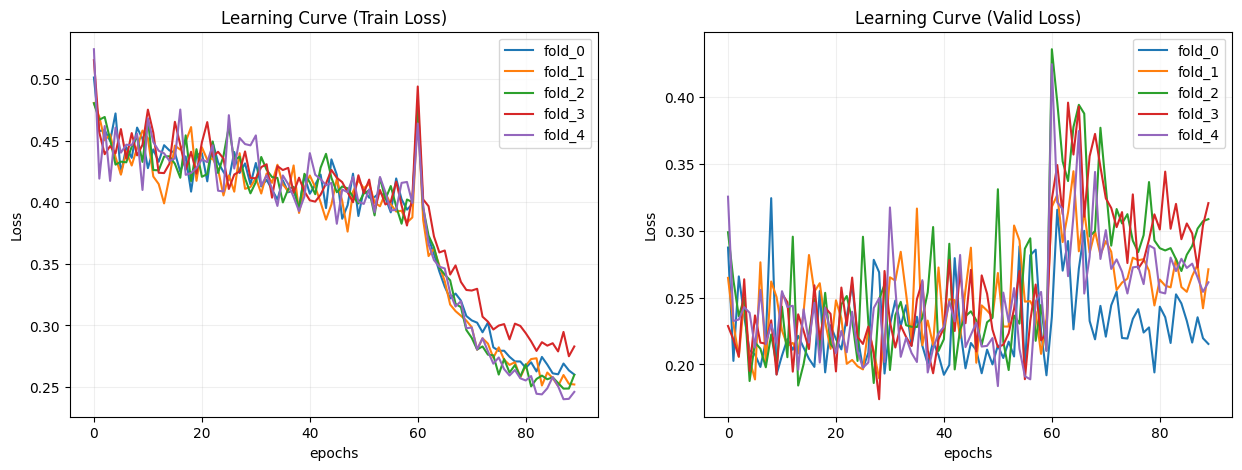

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # 1行2列のサブプロットを作成

for i, his in enumerate(list_history):
    axes[0].plot(his["Train Loss"], label=f"fold_{i}")  # 1つ目のサブプロットにTrain Lossを描画
    axes[1].plot(his["Valid Loss"], label=f"fold_{i}")  # 2つ目のサブプロットにValid Lossを描画

axes[0].set_title("Learning Curve (Train Loss)")
axes[0].set_ylabel("Loss")
axes[0].set_xlabel("epochs")
axes[0].legend()
axes[0].grid(alpha=0.2)
# axes[0].set_ylim([0, 1])

axes[1].set_title("Learning Curve (Valid Loss)")
axes[1].set_ylabel("Loss")
axes[1].set_xlabel("epochs")
axes[1].legend()
axes[1].grid(alpha=0.2)
# axes[1].set_ylim([0, 1])


# PillowのImageオブジェクトに変換
# img = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())

# wandbに記録
# wandb.log({"learning_curve_loss": wandb.Image(img)})

plt.show()

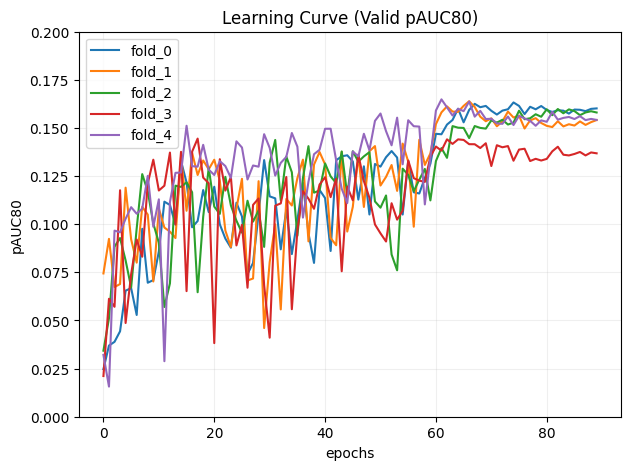

In [31]:
fig, ax = plt.subplots(figsize=(7, 5))  # 1列のサブプロットを作成

for i, his in enumerate(list_history):
    ax.plot(his["Valid AUROC"], label=f"fold_{i}")  # Valid AUROCのみを描画

ax.set_title("Learning Curve (Valid pAUC80)")
ax.set_ylabel("pAUC80")
ax.set_xlabel("epochs")
ax.legend()
ax.grid(alpha=0.2)
ax.set_ylim([0, 0.2])

# PillowのImageオブジェクトに変換
# img = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())

# # wandbに記録
# wandb.log({"learning_curve_pAUC80": wandb.Image(img)})

plt.show()

In [32]:
if WANDB:
    data = [[x, y] for (x, y) in zip(range(len(his["Valid AUROC"].values)), his["Valid AUROC"].values)]
    table = wandb.Table(data=data, columns=["x", "y"])
    wandb.log(
        {
            "learning_curve_pAUC80": wandb.plot.line(
                table, "x", "y", title="Learning Curve (Valid pAUC80)"
            )
        }
    )

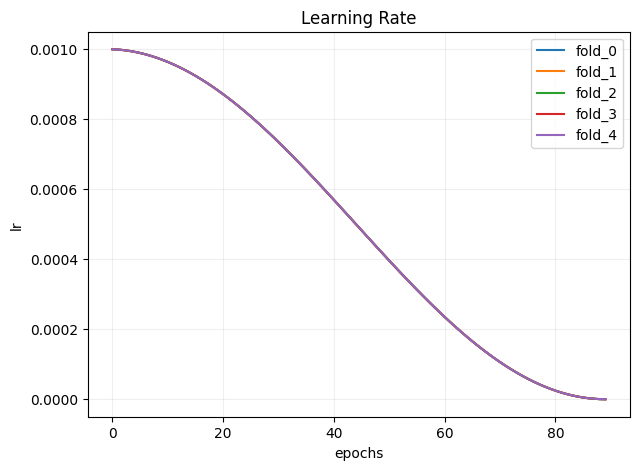

In [33]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.grid(alpha=0.2)
for i, his in enumerate(list_history):
    ax.plot(his["lr"], label=f"fold_{i}")  # 1つ目のサブプロットにTrain Lossを描画

ax.set_title("Learning Rate")
ax.set_ylabel("lr")
ax.set_xlabel("epochs")
ax.legend()

plt.show()

In [34]:
pd.options.display.precision = 4

df_pauc = pd.DataFrame(columns=["pAUC80"])
for i, his in enumerate(list_history):
    df_pauc.loc[f"fold_{i}", "pAUC80"] = his["Valid AUROC"].values[-1]

# df_pauc["pAUC80_notFiltered"] = list_score_notFiltered
df_pauc.loc["mean", "pAUC80"] = np.mean(df_pauc["pAUC80"])
df_pauc.loc["std", "pAUC80"] = np.std(df_pauc["pAUC80"])
# df_pauc.loc["mean", "pAUC80_notFiltered"] = np.mean(df_pauc["pAUC80_notFiltered"])
# df_pauc.loc["std", "pAUC80_notFiltered"] = np.std(df_pauc["pAUC80_notFiltered"])
df_pauc

,pAUC80
fold_0,0.1602
fold_1,0.1541
fold_2,0.158
fold_3,0.1368
fold_4,0.1542
mean,0.1527
std,0.0075


In [35]:
if WANDB:
    wandb.log({"pAUC80_fold0": df_pauc.loc["fold_0", "pAUC80"]})
    wandb.log({"pAUC80_fold1": df_pauc.loc["fold_1", "pAUC80"]})
    wandb.log({"pAUC80_fold2": df_pauc.loc["fold_2", "pAUC80"]})
    wandb.log({"pAUC80_fold3": df_pauc.loc["fold_3", "pAUC80"]})
    wandb.log({"pAUC80_fold4": df_pauc.loc["fold_4", "pAUC80"]})
    wandb.log({"pAUC80_mean": df_pauc.loc["mean", "pAUC80"]})

    # wandb.log({"pAUC80_fold0_notFiltered": df_pauc.loc["fold_0", "pAUC80_notFiltered"]})
    # wandb.log({"pAUC80_fold1_notFiltered": df_pauc.loc["fold_1", "pAUC80_notFiltered"]})
    # wandb.log({"pAUC80_fold2_notFiltered": df_pauc.loc["fold_2", "pAUC80_notFiltered"]})
    # wandb.log({"pAUC80_fold3_notFiltered": df_pauc.loc["fold_3", "pAUC80_notFiltered"]})
    # wandb.log({"pAUC80_fold4_notFiltered": df_pauc.loc["fold_4", "pAUC80_notFiltered"]})
    # wandb.log({"pAUC80_mean_notFiltered": df_pauc.loc["mean", "pAUC80_notFiltered"]})

    wandb.finish()

pAUC80_fold0,▁
pAUC80_fold1,▁
pAUC80_fold2,▁
pAUC80_fold3,▁
pAUC80_fold4,▁
pAUC80_mean,▁
pAUC80_fold0,0.16017
pAUC80_fold1,0.15412
pAUC80_fold2,0.15804
pAUC80_fold3,0.13683
pAUC80_fold4,0.15417


In [36]:
# wandb.finish()

In [37]:
# for fold in range(5):
#     score = df_pauc.loc[f"fold_{fold}", "pAUC80_notFiltered"]
#     print("==="*10)
#     print(f"Fold{fold} (Score: {score:.4f})")
#     print("==="*10)
#     tmp = list_df_pos_pred[fold].sort_values(by="pred", ascending=False).reset_index(drop=True)
#     tmp["Rank"] = tmp.index
#     tmp["Rank_percent"] = 100 * tmp["Rank"] / len(tmp) 
#     pos = tmp.loc[tmp["target"]==1, ["isic_id", "patient_id", "Rank", "Rank_percent", "pred"]].reset_index(drop=True)
#     display(pos.tail(10))
#     print()